# Read Before

- https://www.kaggle.com/code/raddar/icr-competition-analysis-and-findings/notebook
- https://www.tensorflow.org/guide/core/logistic_regression_core
- https://www.kaggle.com/code/muelsamu/simple-tabpfn-approach-for-score-of-15-in-1-min/notebook

Plan:
- [x] Feature Engineering (1 day)
- [x] CV and Model Selection (1 day)
- [x] Validation (1 day)
- [x] Review
- [x] Make Artefacts -> Made Utility script for WoE
- [x] Solve Error With Solution -> Made If new catgory then choose worst WoEs (Can make two splits woth worst and other value )
- [x] Add TabPFN (Added Private Sample with package files) and No CV TabPFN preds
- [x] Added Weighted Submition with respect to Competion Metric Mean
- [x] Refactor More Accurately train RF part & Make Dev branch for Git
- [x] Experiment with GadientClassifier and Parameters ( Tried GadientClassifier / Added Better displayed TOC )
- [x] CV TabPFN - looks even inferior to GBT. May be due to preprosessing.
- [x] Ensembled into Submition results from several Classifiers (There is aa room for Playing with manually assigned weights)
- [x] Due to time consideration -> SUBMITION: bool
- [ ] Submition Error When calculating results.
- [ ] Rethink CV (check dimension) v31->v32,
- [x] Solve problem with accuracy (showns NaNs) -> Changed to Binary Accuracy version
- [ ] Research wheather it is possoble to train with respect to Gradient of the metric.
- [ ] Found that some variables are constant as they represent some features for categroical column which takes only two values, so makes sense to drop them in order not overtrain. I will make split -> make two versions of model which is run if Group A (on all data), which is Group B ( which finetuned after )

In [1]:
SUBMITION = False

## Install TabPFN offline

In [2]:
!pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr

!mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff

!cp /kaggle/input/pip-packages-icr/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Looking in links: file:///kaggle/input/pip-packages-icr
Processing /kaggle/input/pip-packages-icr/tabpfn-0.1.9-py3-none-any.whl


# Import Utils

In [3]:
from woe_utils import WOENumericalComplex

# Import Standard Libs

In [4]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from keras import metrics # accuracy
from keras import backend as K

import keras_tuner as kt

import pandas as pd
from pandas.api.types import is_numeric_dtype

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import StratifiedKFold, KFold

from tabpfn import TabPFNClassifier

import warnings
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 500)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load the Dataset

In [5]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv', index_col='Id')
dataset_df.columns = dataset_df.columns.str.rstrip()
print("Full train dataset shape is {}".format(dataset_df.shape))

dataset_test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv', index_col='Id')
dataset_test_df.columns = dataset_test_df.columns.str.rstrip()
print("Full test dataset shape is {}".format(dataset_test_df.shape))

Full train dataset shape is (617, 57)
Full test dataset shape is (5, 56)


# Compute Basic Info

In [6]:
def compute_basic_stats(columns, df):
    out = {}
    
    for i in tqdm(columns):
        mask = df[i].notna()
        
        out[i] = {'nunique':df[i].nunique(),
                  'na_share':round(100*df[i].isna().sum()/df[i].count(),1),
                  'dtype':df[i].dtype
                 }
        if is_numeric_dtype(df[i]):
            out[i]['correlation'] = round(np.corrcoef(x=df.loc[mask,i],y=df.loc[mask,'Class'])[0,1],2)
            out[i]['min'] = df.loc[mask,i].min()
            out[i]['max'] = df.loc[mask,i].max()
            out[i]['std'] = df.loc[mask,i].std()
            out[i]['mean'] = df.loc[mask,i].mean()
            i_lorreg = LogisticRegression()
            X = df.loc[mask,i].values.reshape(-1,1)
            y = df.loc[mask,'Class'].values
            i_lorreg.fit(X=X, y=y)
            y_pred = i_lorreg.predict(X)
            out[i]['logloss'] = log_loss(y_true=y, y_pred=y_pred)
            
            
    out = pd.DataFrame(out).T
    
    out = out.sort_values('logloss',ascending=True)
    
    return out

basic_stats_1 = compute_basic_stats(
    columns=[i for i in dataset_df.columns if i not in ["Id","Class"]],         
    df=dataset_df)

  0%|          | 0/56 [00:00<?, ?it/s]

* Only one variable looks constrant over the target -> better to omit it.
* Realised Better to add LogLoss metric for each feature -> loggloss


# Create Features

In [7]:
def preprocess(train: pd.DataFrame, test: pd.DataFrame, stats: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, dict):
    info = dict()
    woes = dict()
    numeric_features = stats[stats.logloss.notna()].index.tolist() # Cause for EJ logloss is null
    train_out = train.copy()
    test_out = test.copy()
    
    out_features = list()
    
    # Make WoE Columns
    for i in tqdm(numeric_features, 'WoE Encoding: '):
        tmp_woe = WOENumericalComplex()
        tmp_woe.fit(x=train_out[i], y=train_out['Class'])
        train_out[i + '_WoE'] = tmp_woe.transform(X=train_out[i])
        test_out[i + '_WoE'] = tmp_woe.transform(X=test_out[i])
        out_features.append(i + '_WoE')
        woes[i] = tmp_woe
    
    
    # Make NA columns
    for i in tqdm(['DU', 'FC', 'FS', 'CC', 'FL', 'GL', 'CB', 'EL', 'BQ'], 'Split by NA: '):
        train_out[i+'_na'] = np.where(train_out[i].isna(),1,0)
        test_out[i+'_na'] = np.where(test_out[i].isna(),1,0)
        out_features.append(i + '_na')
    
    # Basic Logic -> normalise
    for i in tqdm(numeric_features,'Normalise Numeric: '):
        if stats.loc[i,'correlation'] > 0:
            na_value = stats.loc[i,'max']
        else:
            na_value = stats.loc[i,'min']

        train_out[i] = train_out[i].fillna(na_value)
        test_out[i] = test_out[i].fillna(na_value)

        train_out[i] = (train_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']
        test_out[i] = (test_out[i]-stats.loc[i,'mean'])/stats.loc[i,'std']

        out_features.append(i)
            
            
    # Addition EJ -> has only two values, so if EJ == 'A'
    train_out['EJ' + '_A'] = np.where(train_out['EJ'] == 'A',1,0)
    test_out['EJ' + '_A'] = np.where(test_out['EJ'] == 'A',1,0)
    out_features.append('EJ' + '_A')
    
    return train_out,test_out,out_features, woes


train_out,test_out,features, woes = preprocess(train=dataset_df, test=dataset_test_df, stats=basic_stats_1)

WoE Encoding:   0%|          | 0/55 [00:00<?, ?it/s]

Split by NA:   0%|          | 0/9 [00:00<?, ?it/s]

Normalise Numeric:   0%|          | 0/55 [00:00<?, ?it/s]

In [8]:
basic_stats_2 = compute_basic_stats(
    columns=[i for i in train_out.columns if i not in ["Id","Class"]],         
    df=train_out)

basic_stats_2

  0%|          | 0/121 [00:00<?, ?it/s]

,nunique,na_share,dtype,correlation,min,max,std,mean,logloss
DU_WoE,4,0.0,float64,-0.52,-2.678782,2.977892,1.042059,0.286027,4.790242
FL_WoE,4,0.0,float64,-0.42,-2.045013,2.977892,0.86161,0.214552,5.374418
DI_WoE,3,0.0,float64,-0.37,-2.361247,0.382521,0.698812,0.124925,5.432836
DA_WoE,3,0.0,float64,-0.37,-2.093932,0.463416,0.719046,0.14452,5.549671
GL_WoE,4,0.0,float64,-0.4,-1.805209,2.977892,0.865805,0.230269,5.783341
FD_WoE,3,0.0,float64,-0.33,-1.996604,0.379845,0.635814,0.115675,5.783341
EH_WoE,3,0.0,float64,-0.32,-2.061142,0.343225,0.622624,0.111704,5.841759
EH,127,0.0,float64,0.18,-0.1635,22.876681,1.0,-0.0,5.900177
AM,605,0.0,float64,0.24,-0.513293,8.483647,1.0,0.0,5.900177
BC_WoE,3,0.0,float64,-0.3,-1.9811,0.486565,0.630381,0.116679,5.900177


# Train Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [9]:
def plot_train_logs(model) -> None:

    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()

def train_model(train: pd.DataFrame, test: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6,
                model_obj = tfdf.keras.RandomForestModel,
                model_kwargs = dict(),
                model_compile_kwargs = dict()) -> (pd.DataFrame, dict,  dict):

    # Create a dataframe of required size with zero values.
    out_of_fold = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index)
    submition = pd.DataFrame(data=np.zeros((len(test.index),n_splits)),index=test.index)

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Calculate the number of samples for each label.
    neg, pos = np.bincount(train[label])
    total = neg + pos
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}

    print('Weight for class 0: {:.2f}'.format(weight_for_0))
    print('Weight for class 1: {:.2f}'.format(weight_for_1))
    
    # Names of columns
    submition_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test)
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # We need to convert the datatset from Pandas format (pd.DataFrame)
            # into TensorFlow Datasets format (tf.data.Dataset).
            train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
            valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

            # Define & Train the model and metrics
            model = model_obj(**model_kwargs)
            model.compile(**model_compile_kwargs) 
            model.fit(x=train_ds, class_weight=class_weight)

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            # Store the predictions in out_of_fold dataframe
            out_of_fold.loc[valid_ids, 0] = model.predict(x=valid_ds).flatten()
            submition[i] = model.predict(x=submition_ds).flatten() 

            # Evaluate and store the metrics in respective dicts
            evaluation = model.evaluate(x=train_ds,return_dict=True)
            train_metric = evaluation["balanced_logloss_tf"]
            
            evaluation = model.evaluate(x=valid_ds,return_dict=True)
            val_metric = evaluation["balanced_logloss_tf"]
            
            # Plot Results
            plot_train_logs(model)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
         
    
            
    return submition,models,metrics

def balanced_logloss_tf(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    
    # y_true is prob that y is equals to 1, we assume that final probs would be P(class_1) = 1 - P(class_0)
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = tf.reshape(K.log(y_pred_1),[-1,1])
    log_y_pred_0 = tf.reshape(K.log(y_pred_0),[-1,1])

    y_1 = tf.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -K.dot(y_1,log_y_pred_1)[0][0]/K.sum(y_1)
    logloss_0 = -K.dot(y_0,log_y_pred_0)[0][0]/K.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

# RandomForestModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp6m3ythbc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:09.504786. Found 555 examples.
Training model...
Model trained in 0:00:00.783964
Compiling model...


[INFO 23-07-20 18:56:11.7580 UTC kernel.cc:1242] Loading model from path /tmp/tmp6m3ythbc/model/ with prefix 232a31205fa74c29
[INFO 23-07-20 18:56:11.8975 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34210 node(s), and 113 input feature(s).
[INFO 23-07-20 18:56:11.8976 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:56:11.8977 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 0s 385ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9839 - balanced_logloss_tf: 0.2942


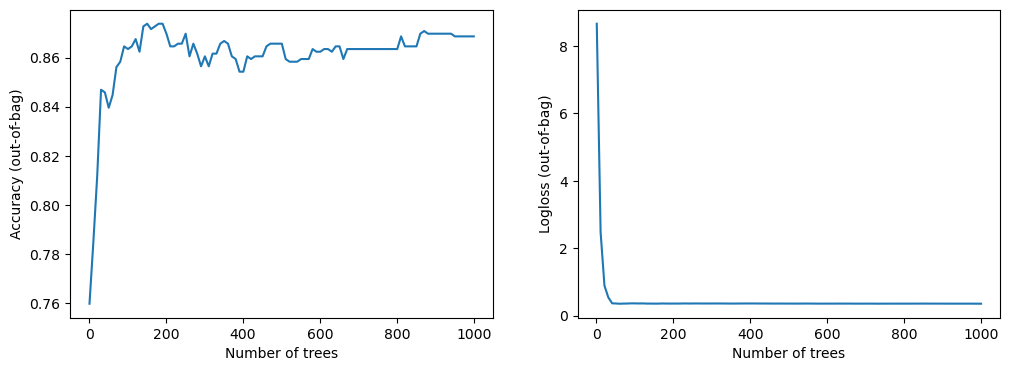


Train: 0.1816 Validation: 0.2942
##### Fold 2
Use /tmp/tmpomz1cqy_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.121697. Found 555 examples.
Training model...
Model trained in 0:00:00.743181
Compiling model...


[INFO 23-07-20 18:56:21.8424 UTC kernel.cc:1242] Loading model from path /tmp/tmpomz1cqy_/model/ with prefix 1d08f2b801d842b0
[INFO 23-07-20 18:56:21.9792 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34512 node(s), and 113 input feature(s).
[INFO 23-07-20 18:56:21.9793 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:56:21.9794 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 374ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_logloss_tf: 0.3145


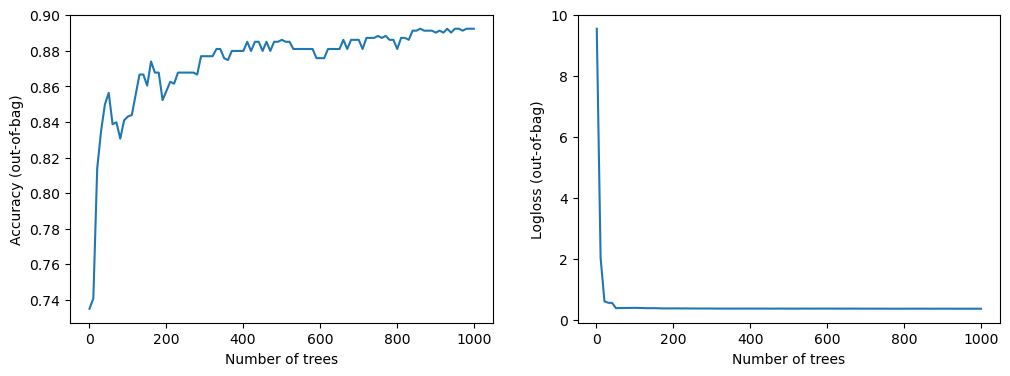


Train: 0.1801 Validation: 0.3145
##### Fold 3
Use /tmp/tmpn0ylbl2k as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.027850. Found 555 examples.
Training model...
Model trained in 0:00:00.738717
Compiling model...


[INFO 23-07-20 18:56:28.9063 UTC kernel.cc:1242] Loading model from path /tmp/tmpn0ylbl2k/model/ with prefix de8e0bf604134a97
[INFO 23-07-20 18:56:29.0449 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34332 node(s), and 113 input feature(s).
[INFO 23-07-20 18:56:29.0452 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 375ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8548 - balanced_logloss_tf: 0.4360


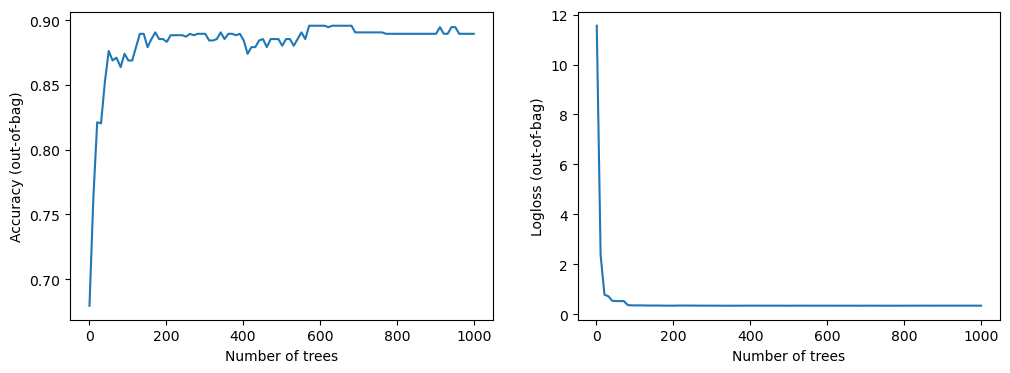


Train: 0.1718 Validation: 0.4360
##### Fold 4
Use /tmp/tmpbpuwwwwy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.024658. Found 555 examples.
Training model...
Model trained in 0:00:00.907112
Compiling model...


[INFO 23-07-20 18:56:36.4839 UTC kernel.cc:1242] Loading model from path /tmp/tmpbpuwwwwy/model/ with prefix 432af4e3bf164360
[INFO 23-07-20 18:56:36.6238 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34210 node(s), and 113 input feature(s).
[INFO 23-07-20 18:56:36.6239 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:56:36.6239 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 379ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8710 - balanced_logloss_tf: 0.3325


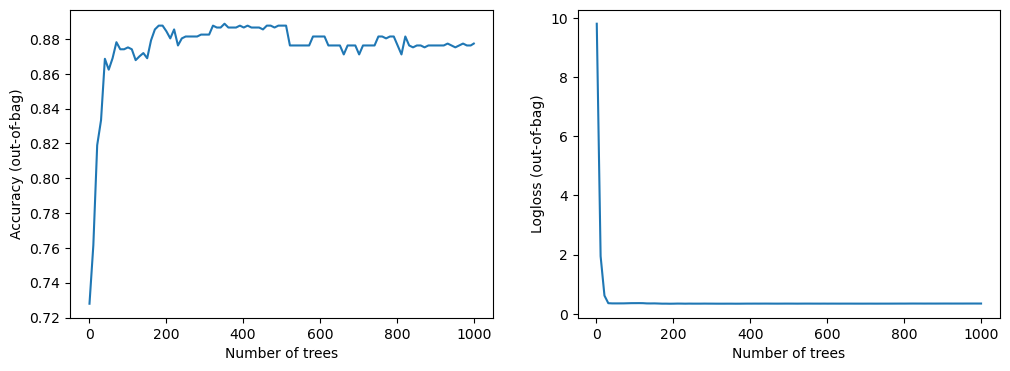


Train: nan Validation: 0.3325
##### Fold 5
Use /tmp/tmp74i5p9ao as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.044703. Found 555 examples.
Training model...
Model trained in 0:00:00.741754
Compiling model...


[INFO 23-07-20 18:56:43.6055 UTC kernel.cc:1242] Loading model from path /tmp/tmp74i5p9ao/model/ with prefix 4d509a85fae34dd3
[INFO 23-07-20 18:56:43.7438 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34614 node(s), and 113 input feature(s).
[INFO 23-07-20 18:56:43.7439 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 379ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_logloss_tf: 0.3191


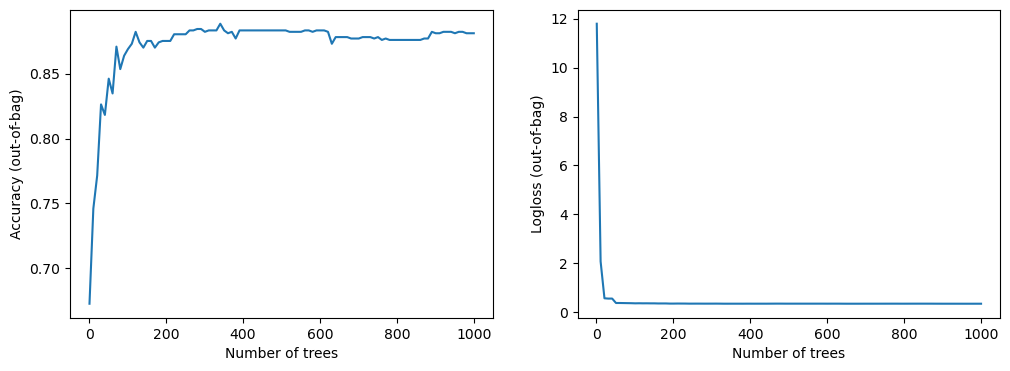


Train: 0.1753 Validation: 0.3191
##### Fold 6
Use /tmp/tmpj4s1_uuw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.011031. Found 555 examples.
Training model...
Model trained in 0:00:00.739200
Compiling model...


[INFO 23-07-20 18:56:50.6275 UTC kernel.cc:1242] Loading model from path /tmp/tmpj4s1_uuw/model/ with prefix 2ab51c77c20640a5
[INFO 23-07-20 18:56:50.7625 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34414 node(s), and 113 input feature(s).
[INFO 23-07-20 18:56:50.7626 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:56:50.7627 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 371ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_logloss_tf: 0.3483


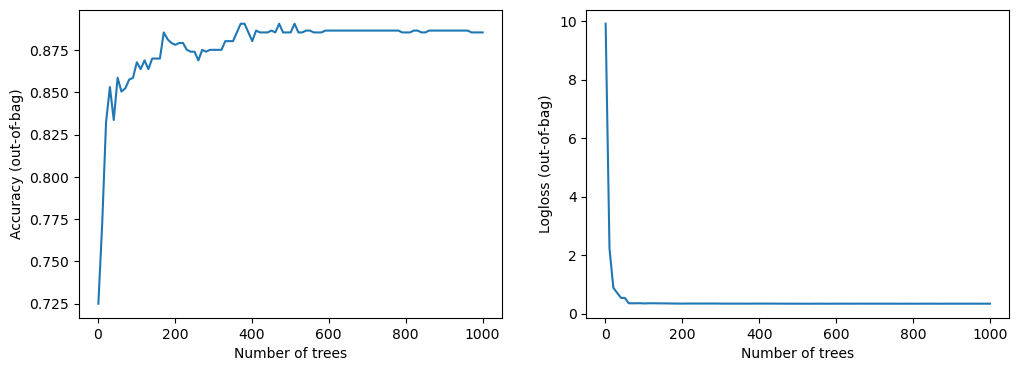


Train: 0.1722 Validation: 0.3483
##### Fold 7
Use /tmp/tmp3stq8ig0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.000511. Found 555 examples.
Training model...
Model trained in 0:00:00.743021
Compiling model...


[INFO 23-07-20 18:56:57.6661 UTC kernel.cc:1242] Loading model from path /tmp/tmp3stq8ig0/model/ with prefix d9ffa9bc541a4674
[INFO 23-07-20 18:56:57.8023 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34550 node(s), and 114 input feature(s).
[INFO 23-07-20 18:56:57.8024 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 372ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_logloss_tf: 0.3973


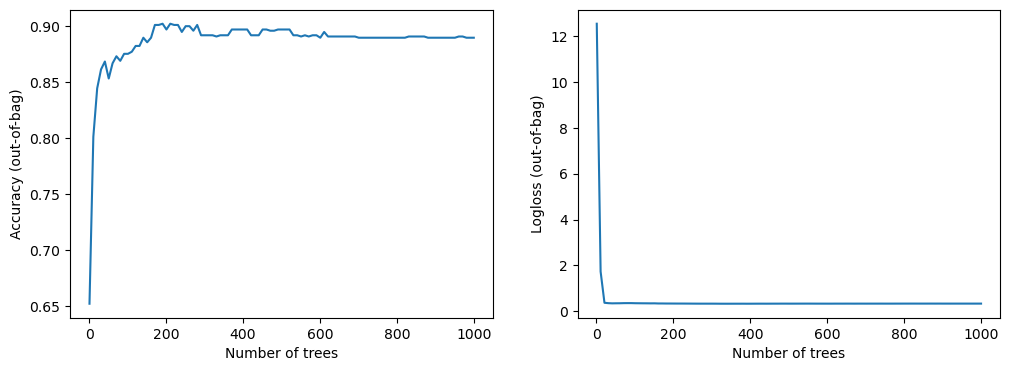


Train: 0.1711 Validation: 0.3973
##### Fold 8
Use /tmp/tmpxcqf8aou as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.030230. Found 556 examples.
Training model...
Model trained in 0:00:00.735885
Compiling model...


[INFO 23-07-20 18:57:05.1649 UTC kernel.cc:1242] Loading model from path /tmp/tmpxcqf8aou/model/ with prefix 938e8cd9033f4118
[INFO 23-07-20 18:57:05.3046 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34432 node(s), and 113 input feature(s).
[INFO 23-07-20 18:57:05.3050 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:57:05.3051 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 379ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_logloss_tf: 0.3383


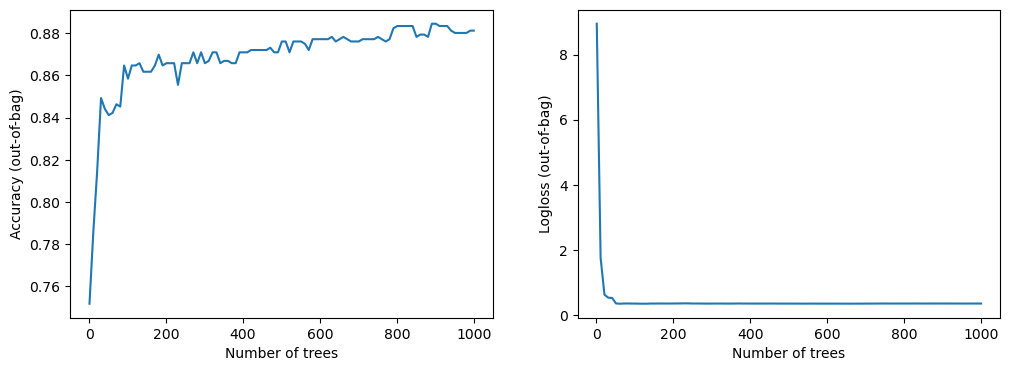


Train: 0.1769 Validation: 0.3383
##### Fold 9
Use /tmp/tmpnu9zqafq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.044248. Found 556 examples.
Training model...
Model trained in 0:00:00.725720
Compiling model...


[INFO 23-07-20 18:57:12.9299 UTC kernel.cc:1242] Loading model from path /tmp/tmpnu9zqafq/model/ with prefix 6a96ce2799664672
[INFO 23-07-20 18:57:13.0629 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34142 node(s), and 113 input feature(s).
[INFO 23-07-20 18:57:13.0630 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 383ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_logloss_tf: 0.3867


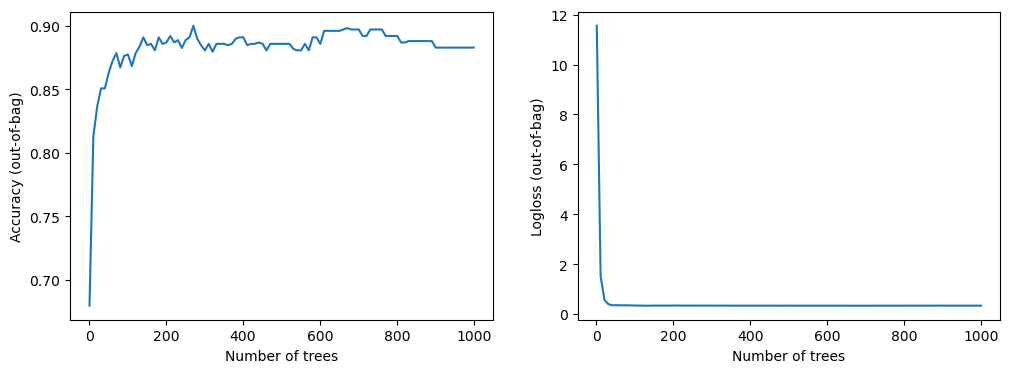


Train: 0.1734 Validation: 0.3867
##### Fold 10
Use /tmp/tmpfqqmfjg0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.033821. Found 556 examples.
Training model...
Model trained in 0:00:00.733977
Compiling model...


[INFO 23-07-20 18:57:20.0059 UTC kernel.cc:1242] Loading model from path /tmp/tmpfqqmfjg0/model/ with prefix 690d2a6274d6471b
[INFO 23-07-20 18:57:20.1443 UTC decision_forest.cc:660] Model loaded with 1000 root(s), 34820 node(s), and 113 input feature(s).
[INFO 23-07-20 18:57:20.1444 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:57:20.1444 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_logloss_tf: 0.2814


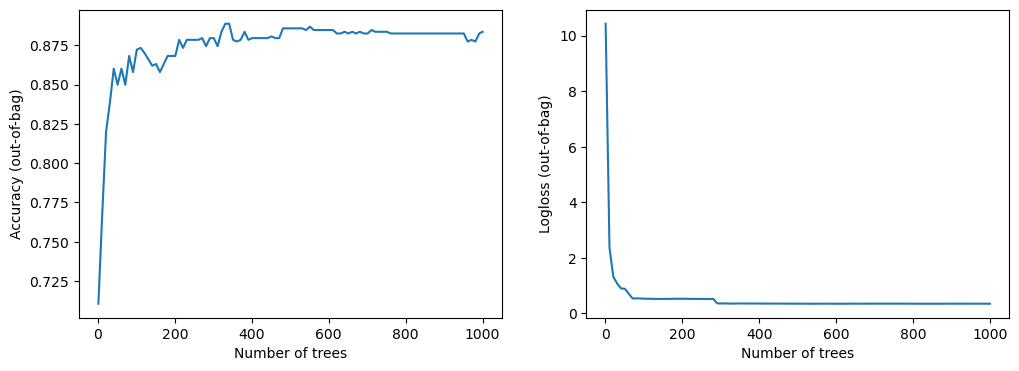


Train: 0.1784 Validation: 0.2814

Train mean: 0.1756 std: 0.0038

Validation mean: 0.3448 std: 0.0485


In [10]:
# RandomForestModel

if not SUBMITION:
    submition_rf_1, model_rf_1,metrics_rf_1 = train_model(
        train=train_out,test=test_out, features=features,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.RandomForestModel,           
        model_kwargs=dict(max_depth=6, num_trees=1000),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp1dx4amyr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.017289. Found 555 examples.
Training model...
Model trained in 0:00:00.232190
Compiling model...


[INFO 23-07-20 18:57:26.7919 UTC kernel.cc:1242] Loading model from path /tmp/tmp1dx4amyr/model/ with prefix 338d523dce474722
[INFO 23-07-20 18:57:26.8330 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10190 node(s), and 112 input feature(s).
[INFO 23-07-20 18:57:26.8331 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 373ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_logloss_tf: 0.3015


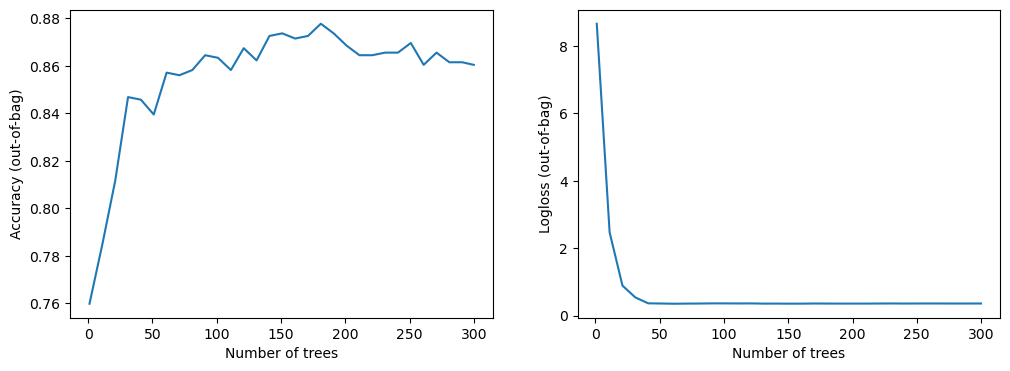


Train: nan Validation: 0.3015
##### Fold 2
Use /tmp/tmplp6jyntc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.017207. Found 555 examples.
Training model...
Model trained in 0:00:00.232418
Compiling model...


[INFO 23-07-20 18:57:33.3176 UTC kernel.cc:1242] Loading model from path /tmp/tmplp6jyntc/model/ with prefix 1dca722f9ed94c3b
[INFO 23-07-20 18:57:33.3586 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10330 node(s), and 113 input feature(s).
[INFO 23-07-20 18:57:33.3587 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:57:33.3587 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 383ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_logloss_tf: 0.3116


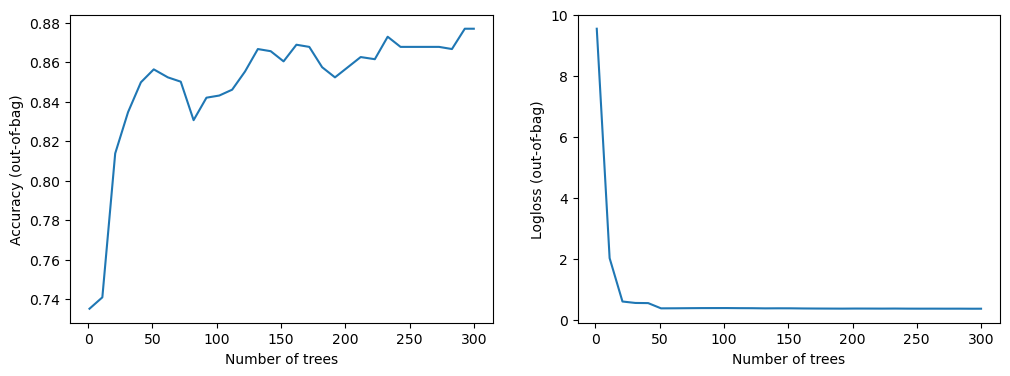


Train: nan Validation: 0.3116
##### Fold 3
Use /tmp/tmp72a6gp4o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.054671. Found 555 examples.
Training model...
Model trained in 0:00:00.233502
Compiling model...


[INFO 23-07-20 18:57:41.1499 UTC kernel.cc:1242] Loading model from path /tmp/tmp72a6gp4o/model/ with prefix d7b66e985b1a4047
[INFO 23-07-20 18:57:41.1909 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10300 node(s), and 112 input feature(s).
[INFO 23-07-20 18:57:41.1910 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8548 - balanced_logloss_tf: 0.4417


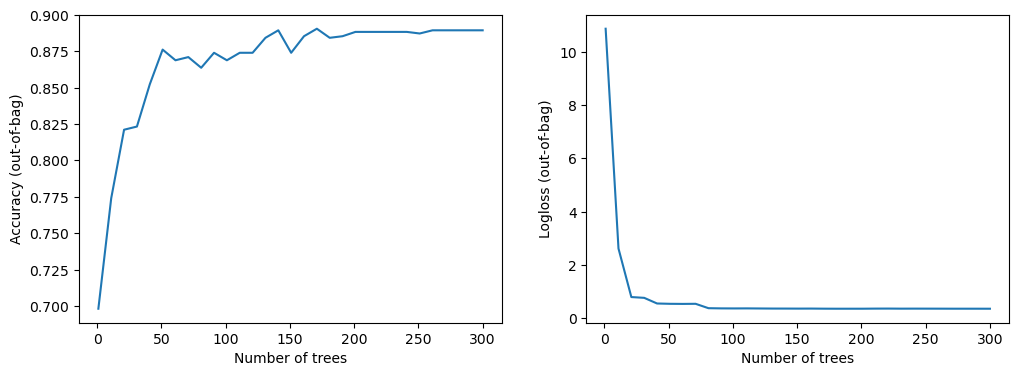


Train: nan Validation: 0.4417
##### Fold 4
Use /tmp/tmpqk0cwc_9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.042725. Found 555 examples.
Training model...
Model trained in 0:00:00.235814
Compiling model...


[INFO 23-07-20 18:57:47.6594 UTC kernel.cc:1242] Loading model from path /tmp/tmpqk0cwc_9/model/ with prefix 4383a537859f4fab
[INFO 23-07-20 18:57:47.7001 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10264 node(s), and 111 input feature(s).
[INFO 23-07-20 18:57:47.7001 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:57:47.7001 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 395ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8710 - balanced_logloss_tf: 0.3305


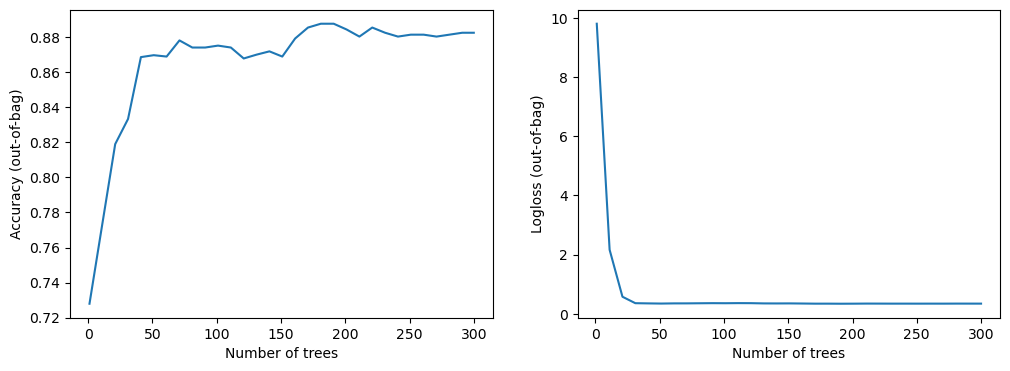


Train: nan Validation: 0.3305
##### Fold 5
Use /tmp/tmpl46mm45r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.018817. Found 555 examples.
Training model...
Model trained in 0:00:00.243072
Compiling model...


[INFO 23-07-20 18:57:54.1793 UTC kernel.cc:1242] Loading model from path /tmp/tmpl46mm45r/model/ with prefix fdec72c31d82427e
[INFO 23-07-20 18:57:54.2223 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10450 node(s), and 112 input feature(s).
[INFO 23-07-20 18:57:54.2223 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 376ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_logloss_tf: 0.3279


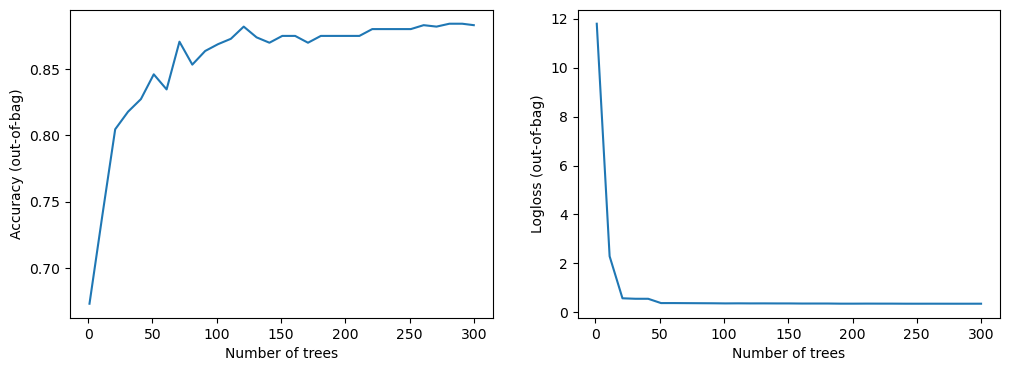


Train: nan Validation: 0.3279
##### Fold 6
Use /tmp/tmphr71ip_8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.023718. Found 555 examples.
Training model...
Model trained in 0:00:00.241351
Compiling model...


[INFO 23-07-20 18:58:00.6549 UTC kernel.cc:1242] Loading model from path /tmp/tmphr71ip_8/model/ with prefix 0b8c8d0e20634a5d
[INFO 23-07-20 18:58:00.6964 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10332 node(s), and 112 input feature(s).
[INFO 23-07-20 18:58:00.6965 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:58:00.6966 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 374ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_logloss_tf: nan


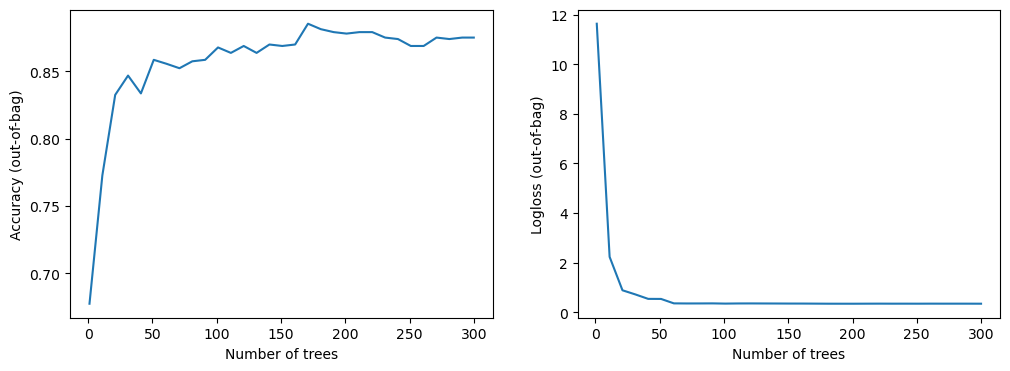


Train: nan Validation: nan
##### Fold 7
Use /tmp/tmpvl4oz3f4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.044992. Found 555 examples.
Training model...
Model trained in 0:00:00.238230
Compiling model...


[INFO 23-07-20 18:58:07.2788 UTC kernel.cc:1242] Loading model from path /tmp/tmpvl4oz3f4/model/ with prefix 2dce9a3b390a4410
[INFO 23-07-20 18:58:07.3203 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10312 node(s), and 112 input feature(s).
[INFO 23-07-20 18:58:07.3204 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 377ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_logloss_tf: 0.4016


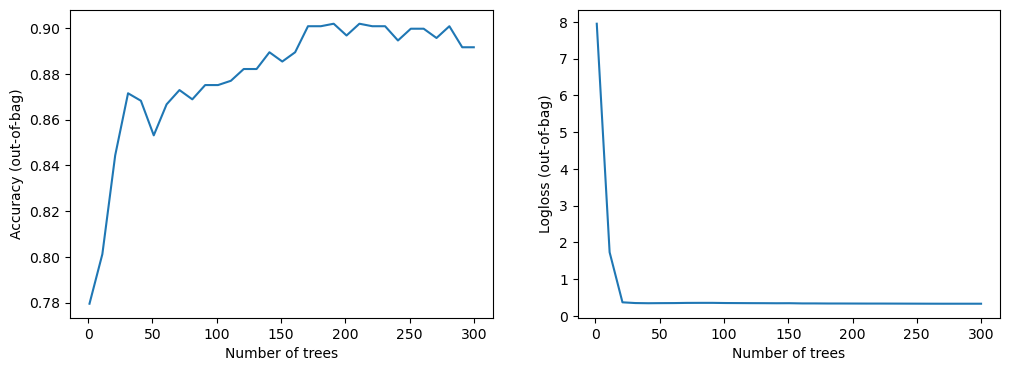


Train: nan Validation: 0.4016
##### Fold 8
Use /tmp/tmpn24ga8ka as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.067308. Found 556 examples.
Training model...
Model trained in 0:00:00.240283
Compiling model...


[INFO 23-07-20 18:58:15.7891 UTC kernel.cc:1242] Loading model from path /tmp/tmpn24ga8ka/model/ with prefix 89a61dfba189474f
[INFO 23-07-20 18:58:15.8308 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10334 node(s), and 112 input feature(s).
[INFO 23-07-20 18:58:15.8309 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:58:15.8309 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 378ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_logloss_tf: 0.3344


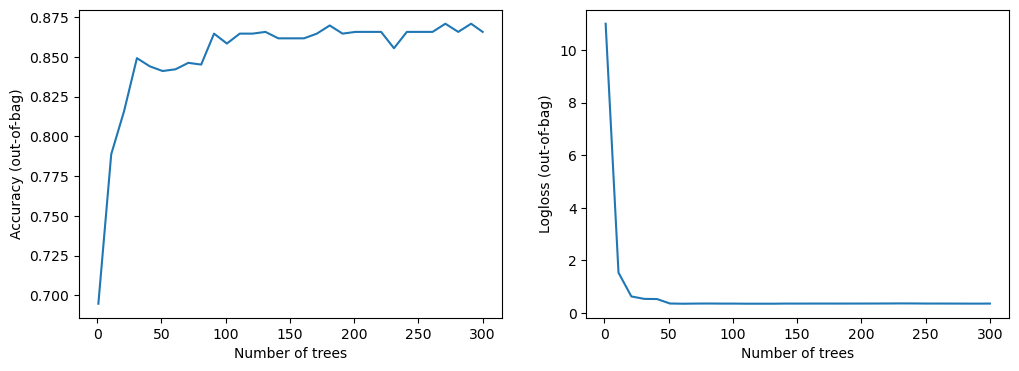


Train: nan Validation: 0.3344
##### Fold 9
Use /tmp/tmp06xkc2qe as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.053711. Found 556 examples.
Training model...
Model trained in 0:00:00.231441
Compiling model...


[INFO 23-07-20 18:58:22.3404 UTC kernel.cc:1242] Loading model from path /tmp/tmp06xkc2qe/model/ with prefix 31d1f71e62644d0d
[INFO 23-07-20 18:58:22.3808 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10174 node(s), and 112 input feature(s).
[INFO 23-07-20 18:58:22.3808 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 377ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_logloss_tf: 0.4160


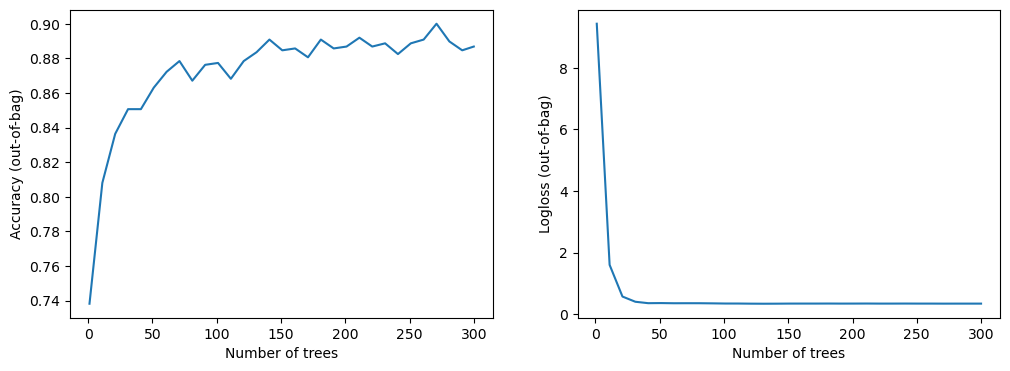


Train: nan Validation: 0.4160
##### Fold 10
Use /tmp/tmpnosfx7s_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:02.052539. Found 556 examples.
Training model...
Model trained in 0:00:00.245880
Compiling model...


[INFO 23-07-20 18:58:28.8837 UTC kernel.cc:1242] Loading model from path /tmp/tmpnosfx7s_/model/ with prefix 32f0c54438aa437a
[INFO 23-07-20 18:58:28.9253 UTC decision_forest.cc:660] Model loaded with 300 root(s), 10428 node(s), and 112 input feature(s).
[INFO 23-07-20 18:58:28.9253 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:58:28.9254 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 377ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_logloss_tf: 0.2804


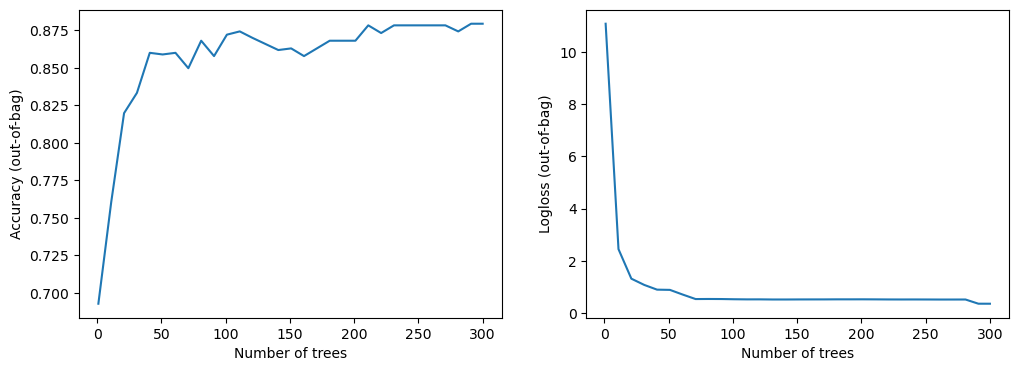


Train: nan Validation: 0.2804

Train mean: nan std: nan

Validation mean: 0.3495 std: 0.0561


In [11]:
# RandomForestModel
if not SUBMITION:
    submition_rf_2, model_rf_2,metrics_rf_2 = train_model(
        train=train_out,test=test_out, features=features,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.RandomForestModel,           
        model_kwargs=dict(max_depth=6, num_trees=300),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpvl4hvxot as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.196612. Found 555 examples.
Training model...
Model trained in 0:00:00.185404
Compiling model...


[INFO 23-07-20 18:58:34.6235 UTC kernel.cc:1242] Loading model from path /tmp/tmpvl4hvxot/model/ with prefix 2416d1b60f4345de
[INFO 23-07-20 18:58:34.6686 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11186 node(s), and 58 input feature(s).
[INFO 23-07-20 18:58:34.6686 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_logloss_tf: 0.2470


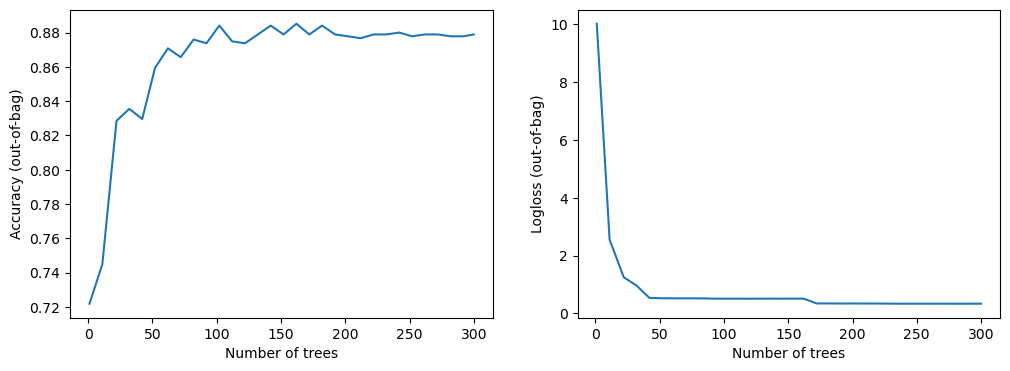


Train: nan Validation: 0.2470
##### Fold 2
Use /tmp/tmp7m5i2ges as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.210339. Found 555 examples.
Training model...
Model trained in 0:00:00.182737
Compiling model...


[INFO 23-07-20 18:58:38.9544 UTC kernel.cc:1242] Loading model from path /tmp/tmp7m5i2ges/model/ with prefix 3d9edff399f243f3
[INFO 23-07-20 18:58:38.9983 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-20 18:58:38.9984 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:58:38.9984 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_logloss_tf: 0.2757


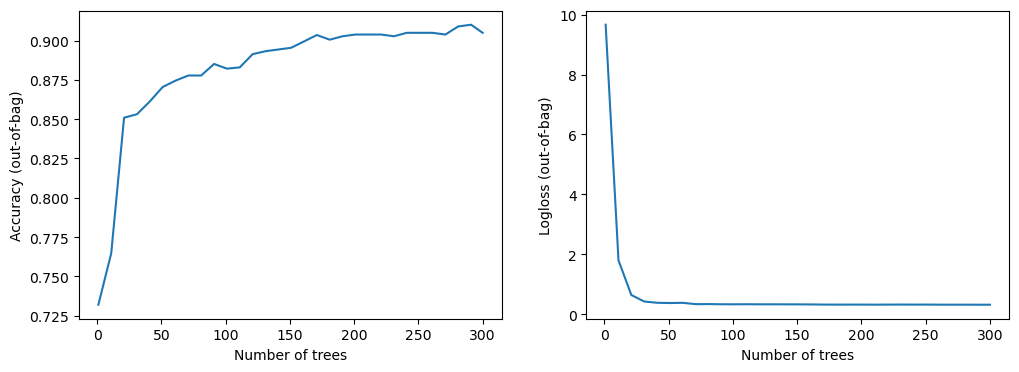


Train: nan Validation: 0.2757
##### Fold 3
Use /tmp/tmpl40cin97 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.194766. Found 555 examples.
Training model...
Model trained in 0:00:00.181841
Compiling model...


[INFO 23-07-20 18:58:43.3589 UTC kernel.cc:1242] Loading model from path /tmp/tmpl40cin97/model/ with prefix 470216a497d3486a
[INFO 23-07-20 18:58:43.4023 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11012 node(s), and 58 input feature(s).
[INFO 23-07-20 18:58:43.4023 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 267ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_logloss_tf: nan


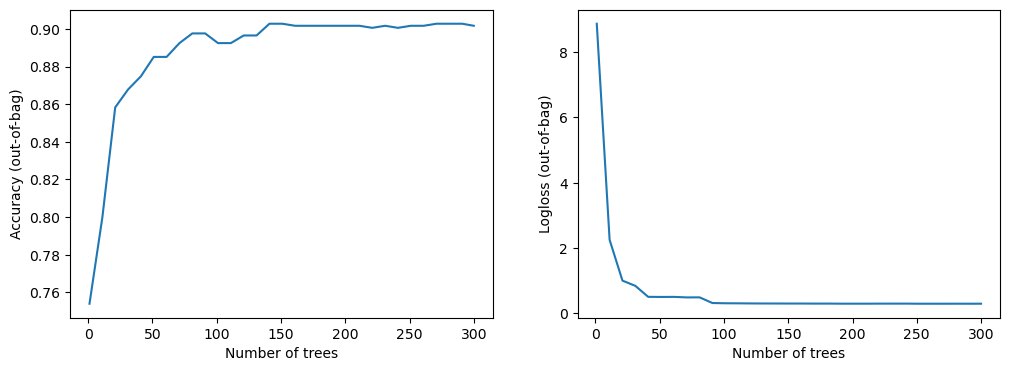


Train: nan Validation: nan
##### Fold 4
Use /tmp/tmp0t93mnyo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.182348. Found 555 examples.
Training model...
Model trained in 0:00:00.183873
Compiling model...


[INFO 23-07-20 18:58:47.6271 UTC kernel.cc:1242] Loading model from path /tmp/tmp0t93mnyo/model/ with prefix 1fdcd56f46ce4c13
[INFO 23-07-20 18:58:47.6711 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11246 node(s), and 58 input feature(s).
[INFO 23-07-20 18:58:47.6711 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 271ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_logloss_tf: nan


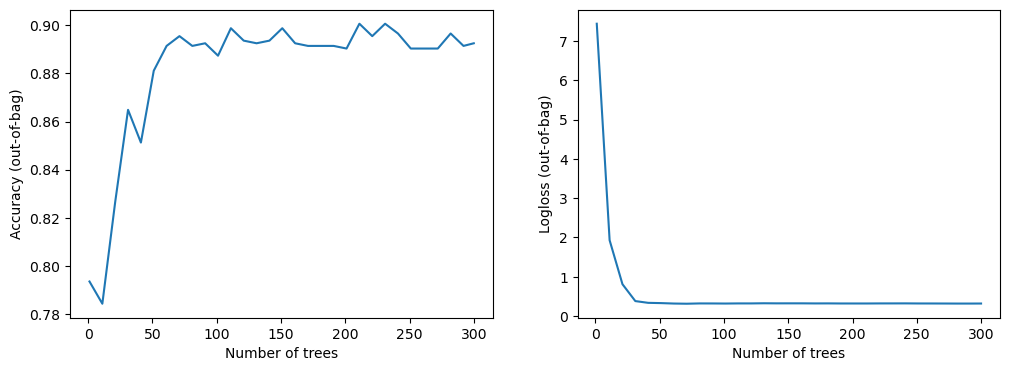


Train: nan Validation: nan
##### Fold 5
Use /tmp/tmpksc57iso as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.229823. Found 555 examples.
Training model...
Model trained in 0:00:00.193841
Compiling model...


[INFO 23-07-20 18:58:51.9522 UTC kernel.cc:1242] Loading model from path /tmp/tmpksc57iso/model/ with prefix 64f9797c774d406d
[INFO 23-07-20 18:58:51.9967 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11294 node(s), and 58 input feature(s).
[INFO 23-07-20 18:58:51.9968 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:58:51.9968 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 280ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_logloss_tf: nan


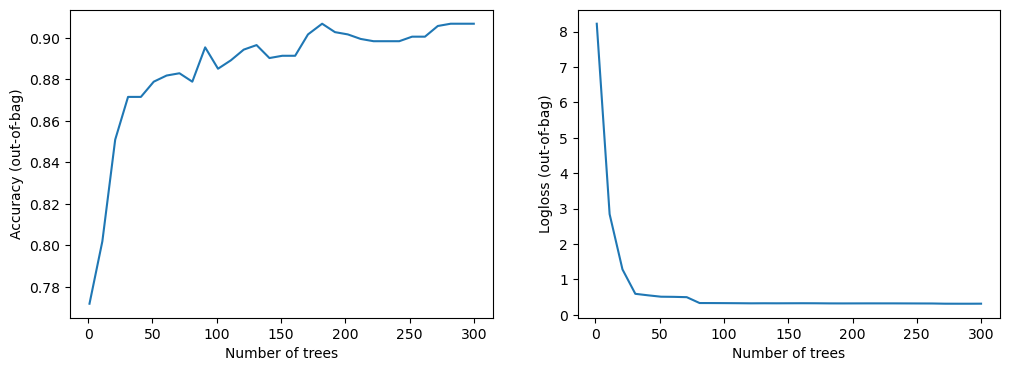


Train: nan Validation: nan
##### Fold 6
Use /tmp/tmp59cayuun as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.223712. Found 555 examples.
Training model...
Model trained in 0:00:00.185940
Compiling model...


[INFO 23-07-20 18:58:57.0826 UTC kernel.cc:1242] Loading model from path /tmp/tmp59cayuun/model/ with prefix af3a37e9c4444974
[INFO 23-07-20 18:58:57.1266 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11238 node(s), and 58 input feature(s).
[INFO 23-07-20 18:58:57.1266 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 278ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_logloss_tf: nan


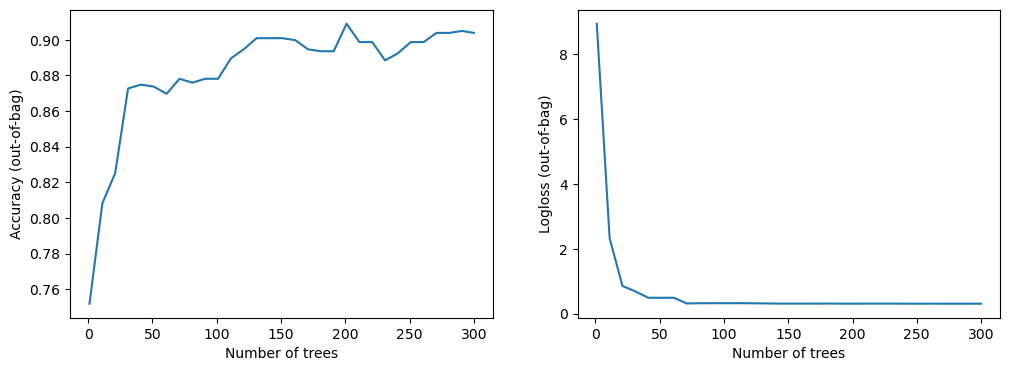


Train: nan Validation: nan
##### Fold 7
Use /tmp/tmpavae_u0t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.236470. Found 555 examples.
Training model...
Model trained in 0:00:00.184631
Compiling model...


[INFO 23-07-20 18:59:01.4819 UTC kernel.cc:1242] Loading model from path /tmp/tmpavae_u0t/model/ with prefix 1b5e4eef60cc4f0c
[INFO 23-07-20 18:59:01.5263 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11262 node(s), and 59 input feature(s).
[INFO 23-07-20 18:59:01.5264 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 273ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_logloss_tf: nan


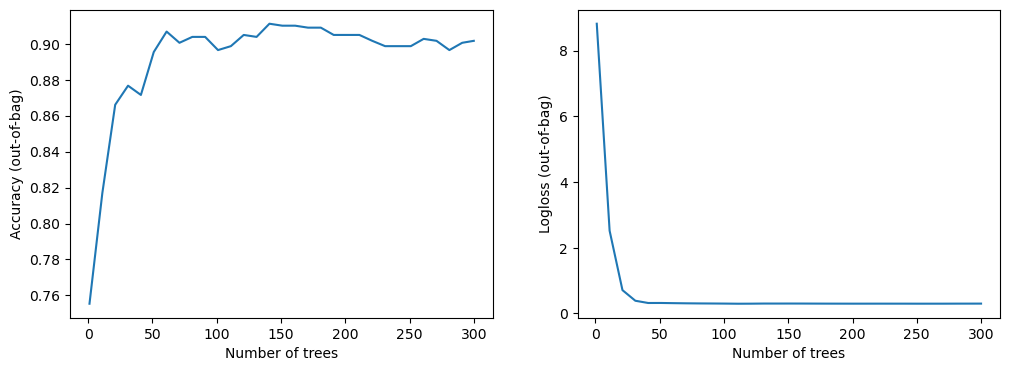


Train: nan Validation: nan
##### Fold 8
Use /tmp/tmp4pvy3udj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.215546. Found 556 examples.
Training model...
Model trained in 0:00:00.187689
Compiling model...


[INFO 23-07-20 18:59:05.7907 UTC kernel.cc:1242] Loading model from path /tmp/tmp4pvy3udj/model/ with prefix c0cb9d02c7d04dd4
[INFO 23-07-20 18:59:05.8361 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11146 node(s), and 58 input feature(s).
[INFO 23-07-20 18:59:05.8361 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-07-20 18:59:05.8361 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 273ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_logloss_tf: nan


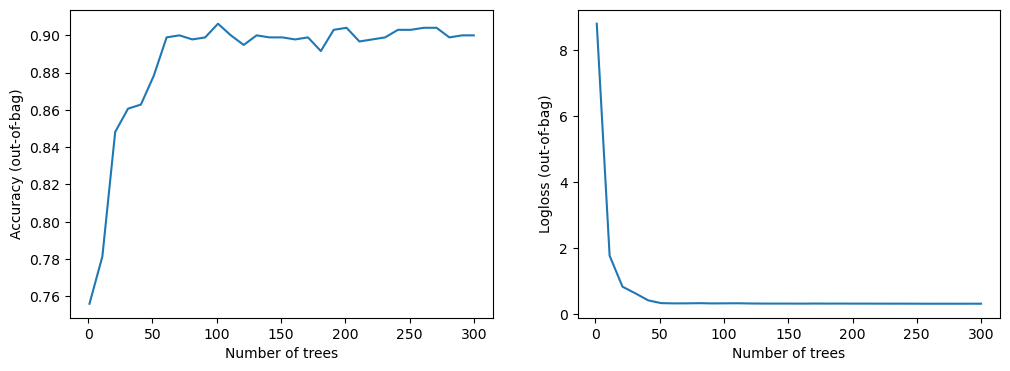


Train: nan Validation: nan
##### Fold 9
Use /tmp/tmply949ns_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.207035. Found 556 examples.
Training model...
Model trained in 0:00:00.185045
Compiling model...


[INFO 23-07-20 18:59:10.0921 UTC kernel.cc:1242] Loading model from path /tmp/tmply949ns_/model/ with prefix c96b594d77a543e4
[INFO 23-07-20 18:59:10.1351 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11126 node(s), and 58 input feature(s).
[INFO 23-07-20 18:59:10.1351 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 278ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_logloss_tf: 0.3449


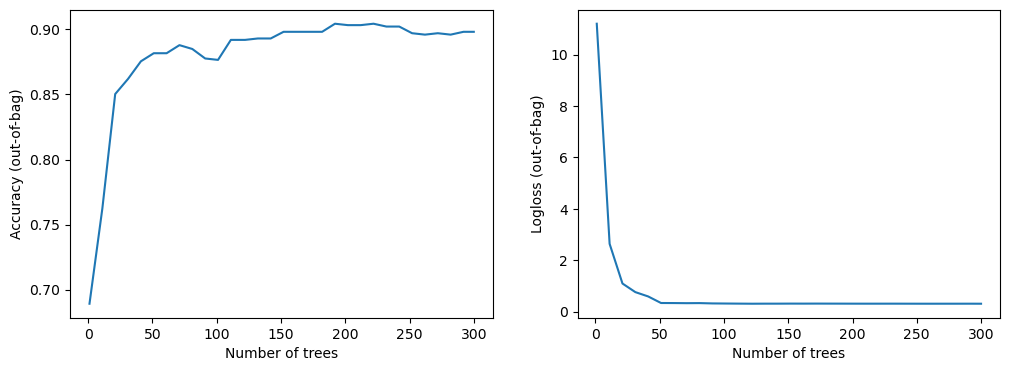


Train: nan Validation: 0.3449
##### Fold 10
Use /tmp/tmpb3l9q2ic as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.224971. Found 556 examples.
Training model...
Model trained in 0:00:00.191725
Compiling model...


[INFO 23-07-20 18:59:14.8936 UTC kernel.cc:1242] Loading model from path /tmp/tmpb3l9q2ic/model/ with prefix 578c2fb7bc014e3e
[INFO 23-07-20 18:59:14.9385 UTC decision_forest.cc:660] Model loaded with 300 root(s), 11154 node(s), and 58 input feature(s).
[INFO 23-07-20 18:59:14.9386 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 269ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9508 - balanced_logloss_tf: 0.2687


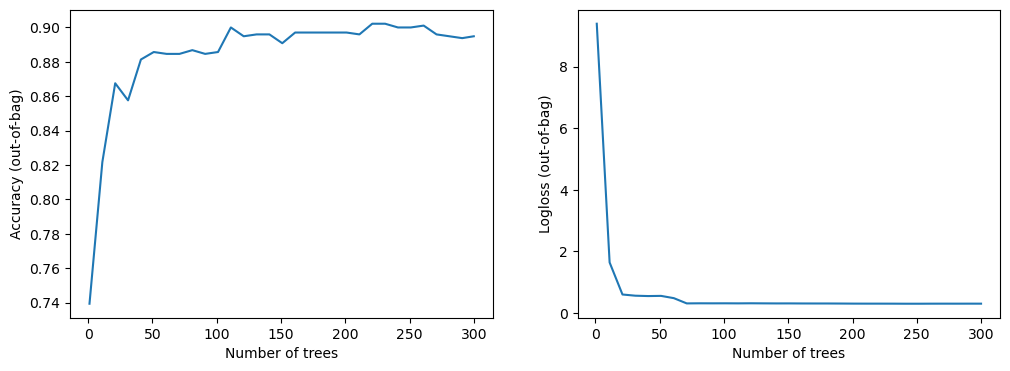


Train: nan Validation: 0.2687

Train mean: nan std: nan

Validation mean: 0.2840 std: 0.0423


In [12]:
# RandomForestModel

features_slice = [i for i in features if len(i) > 2]

submition_rf_3, model_rf_3,metrics_rf_3 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.RandomForestModel,           
    model_kwargs=dict(max_depth=6, num_trees=300),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, balanced_logloss_tf]))

# GradientBoostedTreesModel

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmp11smnf7r as temporary training directory
Reading training dataset...


[WARNING 23-07-20 18:59:18.2803 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:18.2803 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:18.2804 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.198067. Found 555 examples.
Training model...
Model trained in 0:00:02.021712
Compiling model...


[INFO 23-07-20 18:59:21.4878 UTC kernel.cc:1242] Loading model from path /tmp/tmp11smnf7r/model/ with prefix 2b95d606f2d04c57
[INFO 23-07-20 18:59:21.5083 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 18:59:21.5084 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 276ms/step - loss: 0.0000e+00 - binary_accuracy: 1.0000 - balanced_logloss_tf: 0.0299


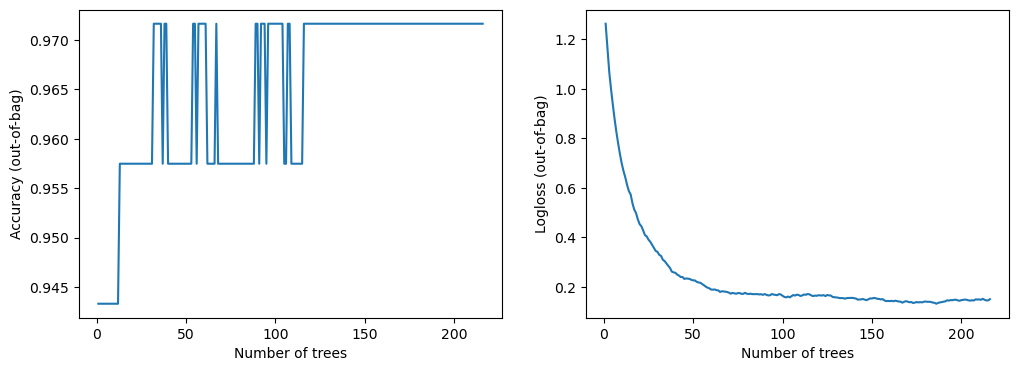


Train: 0.0060 Validation: 0.0299
##### Fold 2
Use /tmp/tmp5mhkl4jo as temporary training directory
Reading training dataset...


[WARNING 23-07-20 18:59:24.3966 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:24.3966 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:24.3967 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.225954. Found 555 examples.
Training model...
Model trained in 0:00:01.815677
Compiling model...


[INFO 23-07-20 18:59:27.4278 UTC kernel.cc:1242] Loading model from path /tmp/tmp5mhkl4jo/model/ with prefix ab99e2a59fbe46f8
[INFO 23-07-20 18:59:27.4463 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9516 - balanced_logloss_tf: 0.1438


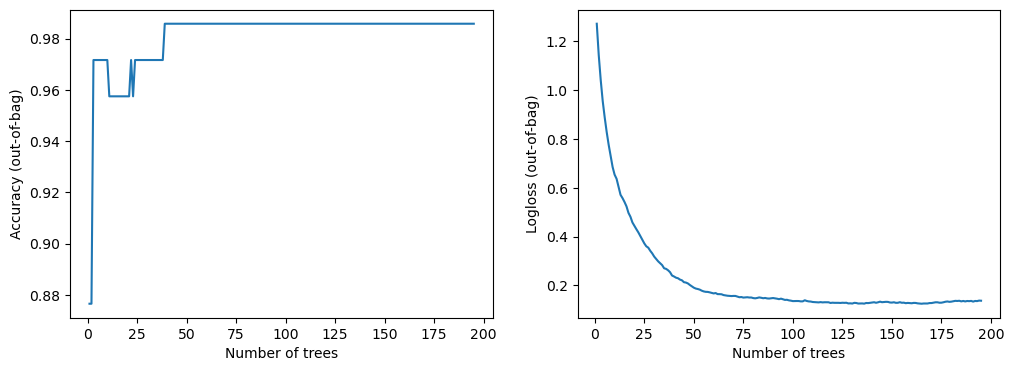


Train: 0.0060 Validation: 0.1438
##### Fold 3
Use /tmp/tmpkc3dry0_ as temporary training directory
Reading training dataset...


[WARNING 23-07-20 18:59:30.3698 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:30.3698 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:30.3699 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.240168. Found 555 examples.
Training model...
Model trained in 0:00:02.329993
Compiling model...


[INFO 23-07-20 18:59:33.9239 UTC kernel.cc:1242] Loading model from path /tmp/tmpkc3dry0_/model/ with prefix 6fe7df79df59470d
[INFO 23-07-20 18:59:33.9480 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 18:59:33.9481 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 274ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_logloss_tf: 0.8838


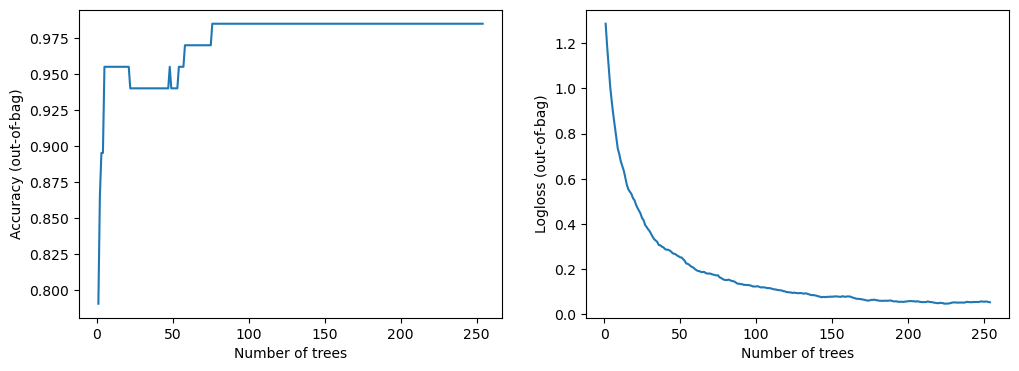


Train: 0.0019 Validation: 0.8838
##### Fold 4
Use /tmp/tmpdk1neyre as temporary training directory
Reading training dataset...


[WARNING 23-07-20 18:59:36.8623 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:36.8624 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:36.8624 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.209359. Found 555 examples.
Training model...
Model trained in 0:00:02.385543
Compiling model...


[INFO 23-07-20 18:59:40.4398 UTC kernel.cc:1242] Loading model from path /tmp/tmpdk1neyre/model/ with prefix 516361e564bd422b
[INFO 23-07-20 18:59:40.4653 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 289ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_logloss_tf: 0.3553


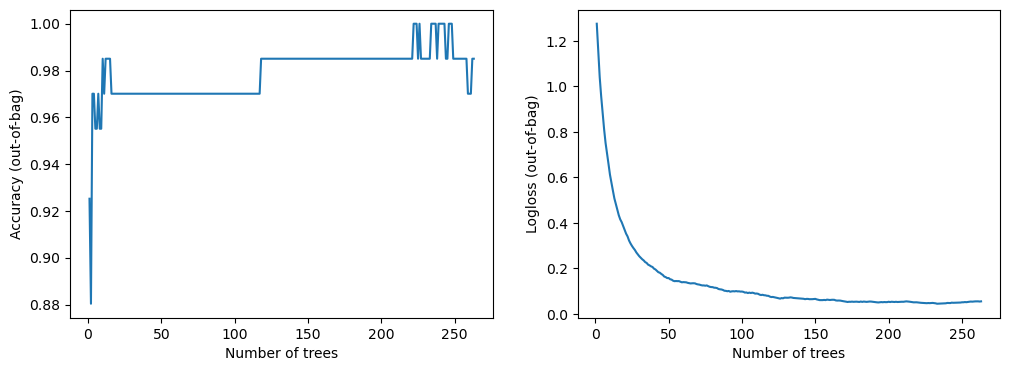


Train: 0.0018 Validation: 0.3553
##### Fold 5
Use /tmp/tmpqgvzpjku as temporary training directory
Reading training dataset...


[WARNING 23-07-20 18:59:43.4387 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:43.4388 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:43.4388 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.220368. Found 555 examples.
Training model...
Model trained in 0:00:02.547469
Compiling model...


[INFO 23-07-20 18:59:47.1882 UTC kernel.cc:1242] Loading model from path /tmp/tmpqgvzpjku/model/ with prefix c0d26a64f42e4718
[INFO 23-07-20 18:59:47.2149 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 18:59:47.2150 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 277ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_logloss_tf: 0.5371


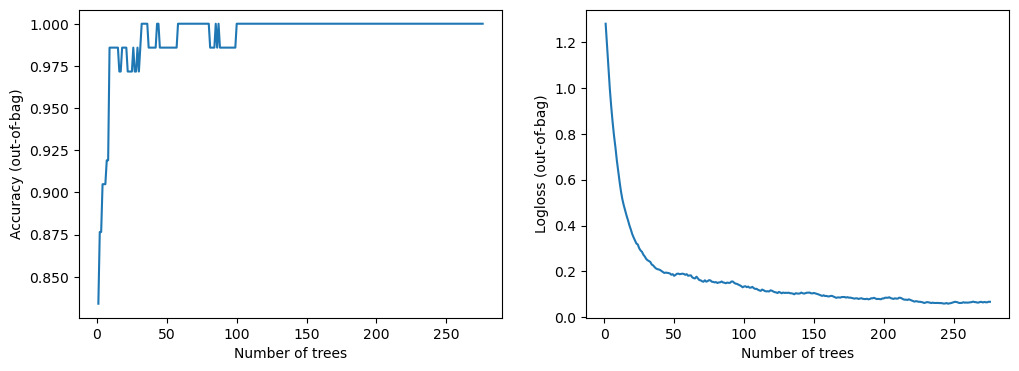


Train: 0.0024 Validation: 0.5371
##### Fold 6
Use /tmp/tmpoqe1885o as temporary training directory
Reading training dataset...


[WARNING 23-07-20 18:59:51.0001 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:51.0001 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:51.0001 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.229670. Found 555 examples.
Training model...
Model trained in 0:00:01.332823
Compiling model...


[INFO 23-07-20 18:59:53.5591 UTC kernel.cc:1242] Loading model from path /tmp/tmpoqe1885o/model/ with prefix 07e5dd0d5d984c1f
[INFO 23-07-20 18:59:53.5716 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 273ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_logloss_tf: 0.2998


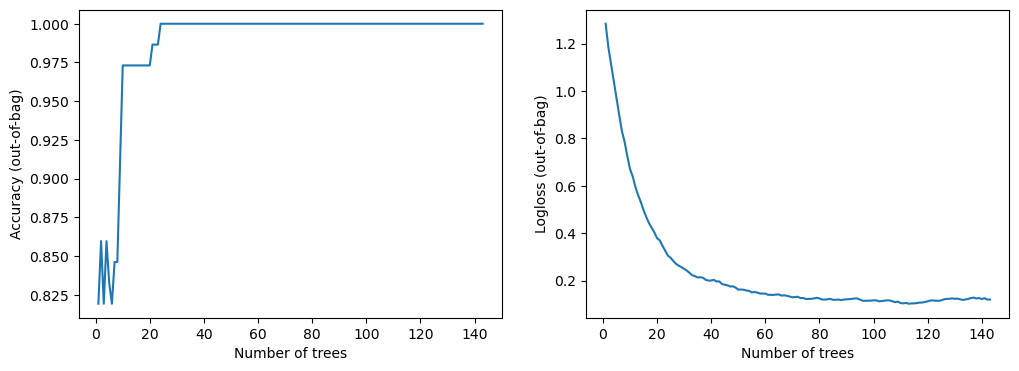


Train: 0.0096 Validation: 0.2998
##### Fold 7
Use /tmp/tmp3ca_0xw_ as temporary training directory
Reading training dataset...


[WARNING 23-07-20 18:59:56.5031 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:56.5031 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 18:59:56.5031 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.275762. Found 555 examples.
Training model...
Model trained in 0:00:00.614996
Compiling model...


[INFO 23-07-20 18:59:58.3992 UTC kernel.cc:1242] Loading model from path /tmp/tmp3ca_0xw_/model/ with prefix 39de4e330e2d4a4d
[INFO 23-07-20 18:59:58.4039 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 18:59:58.4041 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 286ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_logloss_tf: 0.3052


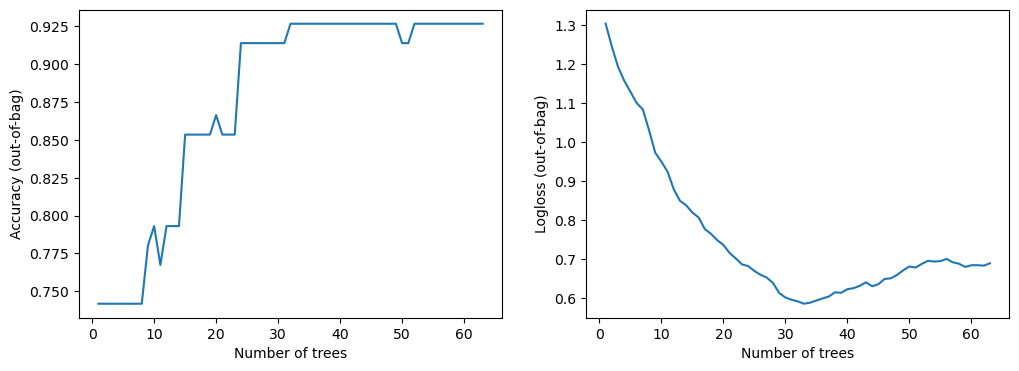


Train: 0.1055 Validation: 0.3052
##### Fold 8
Use /tmp/tmpbrknmd6x as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:00:01.3721 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:01.3722 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:01.3722 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.241365. Found 556 examples.
Training model...
Model trained in 0:00:00.621915
Compiling model...


[INFO 23-07-20 19:00:03.2397 UTC kernel.cc:1242] Loading model from path /tmp/tmpbrknmd6x/model/ with prefix 064fa3000a524eee
[INFO 23-07-20 19:00:03.2444 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 276ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_logloss_tf: 0.3190


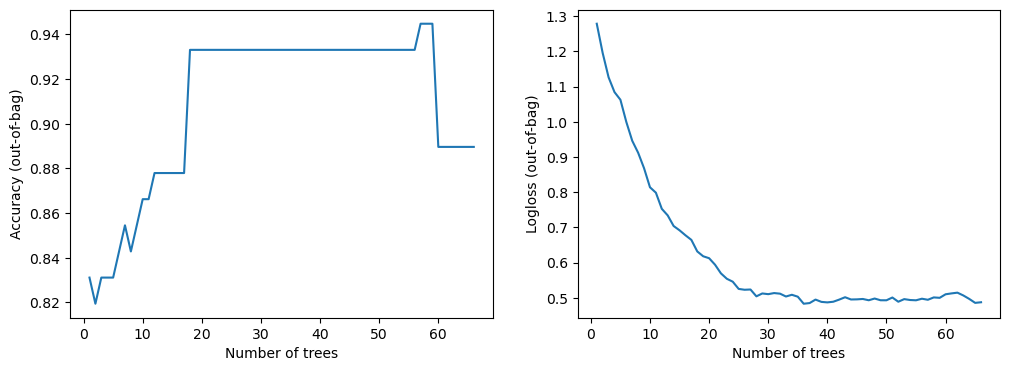


Train: 0.0954 Validation: 0.3190
##### Fold 9
Use /tmp/tmpwc09wkf1 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:00:06.1823 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:06.1823 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:06.1823 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.260990. Found 556 examples.
Training model...
Model trained in 0:00:00.968864
Compiling model...


[INFO 23-07-20 19:00:08.4136 UTC kernel.cc:1242] Loading model from path /tmp/tmpwc09wkf1/model/ with prefix e3f5fb8d2cc14eef
[INFO 23-07-20 19:00:08.4226 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 19:00:08.4227 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 290ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9016 - balanced_logloss_tf: 0.4456


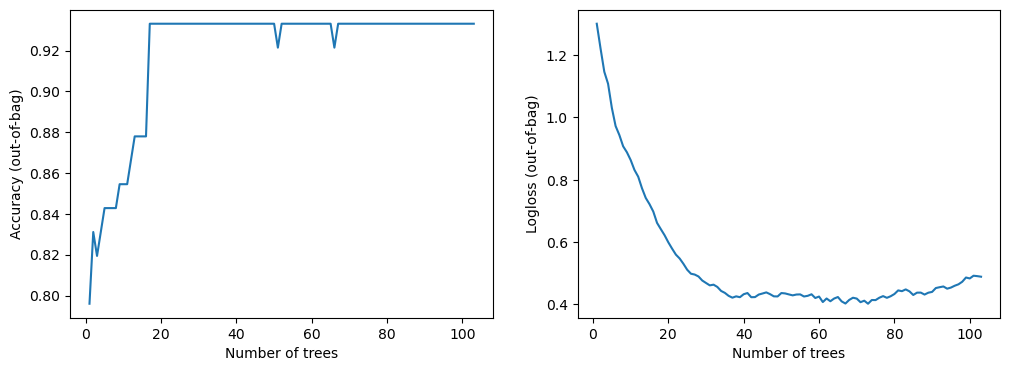


Train: 0.0349 Validation: 0.4456
##### Fold 10
Use /tmp/tmpx1mlbl63 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:00:11.4153 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:11.4153 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:11.4154 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.371043. Found 556 examples.
Training model...
Model trained in 0:00:00.647884
Compiling model...


[INFO 23-07-20 19:00:13.4403 UTC kernel.cc:1242] Loading model from path /tmp/tmpx1mlbl63/model/ with prefix 8974482d9871468e
[INFO 23-07-20 19:00:13.4446 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 277ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9344 - balanced_logloss_tf: 0.2912


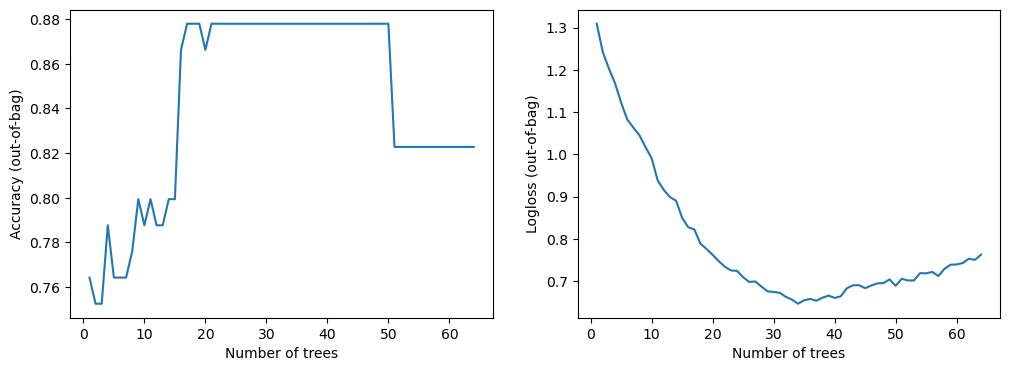


Train: 0.1098 Validation: 0.2912

Train mean: 0.0373 std: 0.0469

Validation mean: 0.3611 std: 0.2314


In [13]:
# GradientBoostedTreesModel

if not SUBMITION:

    features_slice = [i for i in features if len(i) > 2]

    submition_gbt_1, model_gbt_1,metrics_gbt_1 = train_model(
        train=train_out,test=test_out, features=features_slice,                                             
        n_splits=10,                    
        model_obj=tfdf.keras.GradientBoostedTreesModel,            
        model_kwargs=dict(max_depth=5, num_trees=1000),                                                  
        model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, balanced_logloss_tf]))

Weight for class 0: 0.61
Weight for class 1: 2.86
##### Fold 1
Use /tmp/tmpu46q5rr8 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:00:16.7344 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:16.7344 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:16.7345 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.243836. Found 555 examples.
Training model...
Model trained in 0:00:01.030379
Compiling model...


[INFO 23-07-20 19:00:19.0066 UTC kernel.cc:1242] Loading model from path /tmp/tmpu46q5rr8/model/ with prefix b4da91f059f14de8
[INFO 23-07-20 19:00:19.0171 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 19:00:19.0172 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 279ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_logloss_tf: 0.1640


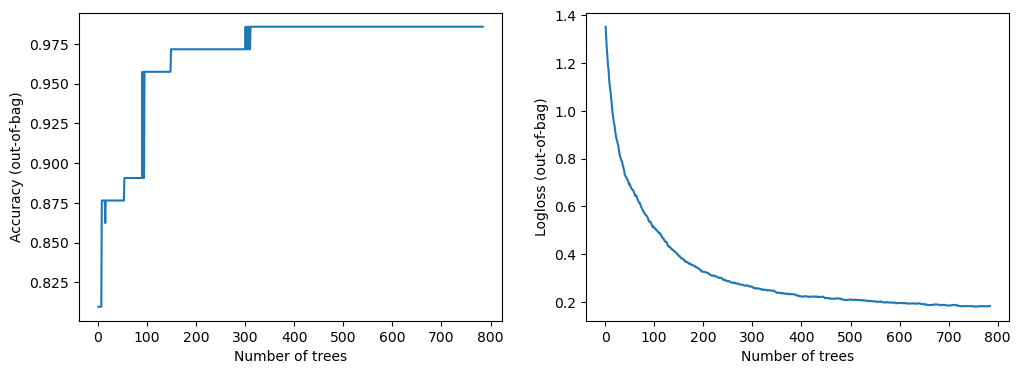


Train: 0.1127 Validation: 0.1640
##### Fold 2
Use /tmp/tmpyvkv7_rt as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:00:22.0102 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:22.0102 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:22.0102 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.266614. Found 555 examples.
Training model...
Model trained in 0:00:00.619676
Compiling model...


[INFO 23-07-20 19:00:23.8997 UTC kernel.cc:1242] Loading model from path /tmp/tmpyvkv7_rt/model/ with prefix e2b315fb59e14db3
[INFO 23-07-20 19:00:23.9060 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 273ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9677 - balanced_logloss_tf: 0.1576


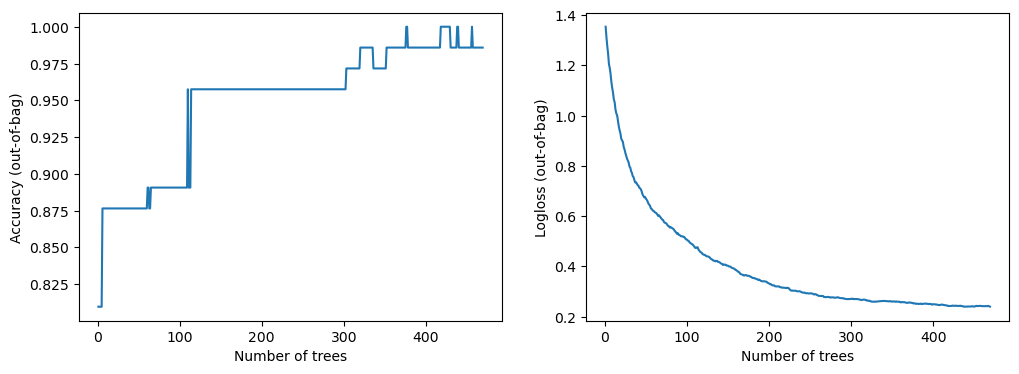


Train: 0.1418 Validation: 0.1576
##### Fold 3
Use /tmp/tmpvlvkmjll as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:00:26.7866 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:26.7867 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:26.7867 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.270086. Found 555 examples.
Training model...
Model trained in 0:00:00.727073
Compiling model...


[INFO 23-07-20 19:00:28.7849 UTC kernel.cc:1242] Loading model from path /tmp/tmpvlvkmjll/model/ with prefix 1a1ed7fddb5b419c
[INFO 23-07-20 19:00:28.7924 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 295ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_logloss_tf: 0.3384


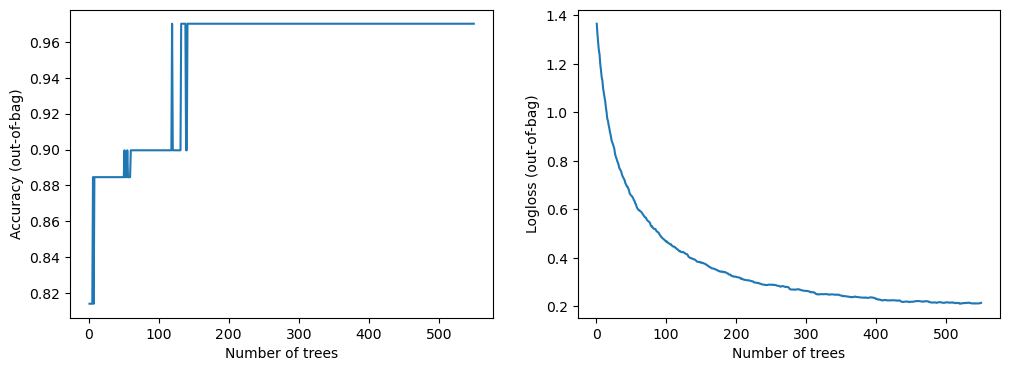


Train: 0.1189 Validation: 0.3384
##### Fold 4
Use /tmp/tmp6upc7be0 as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:00:31.6995 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:31.6995 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:31.6995 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.241141. Found 555 examples.
Training model...
Model trained in 0:00:00.634791
Compiling model...


[INFO 23-07-20 19:00:33.5778 UTC kernel.cc:1242] Loading model from path /tmp/tmp6upc7be0/model/ with prefix 6de4f8a930304564
[INFO 23-07-20 19:00:33.5845 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 19:00:33.5847 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 279ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8871 - balanced_logloss_tf: 0.2671


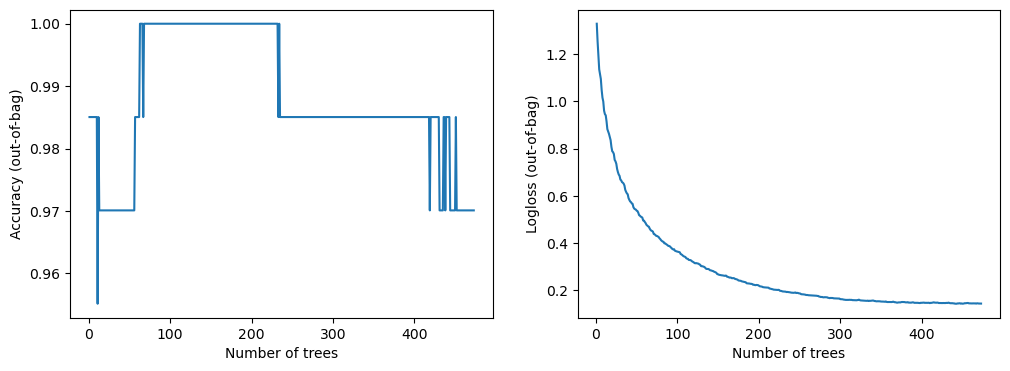


Train: 0.1329 Validation: 0.2671
##### Fold 5
Use /tmp/tmp8ukwpluj as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:00:37.7246 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:37.7246 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:37.7246 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.245432. Found 555 examples.
Training model...
Model trained in 0:00:00.972304
Compiling model...


[INFO 23-07-20 19:00:39.9409 UTC kernel.cc:1242] Loading model from path /tmp/tmp8ukwpluj/model/ with prefix cd14b32b05824195
[INFO 23-07-20 19:00:39.9511 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 277ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9194 - balanced_logloss_tf: 0.2613


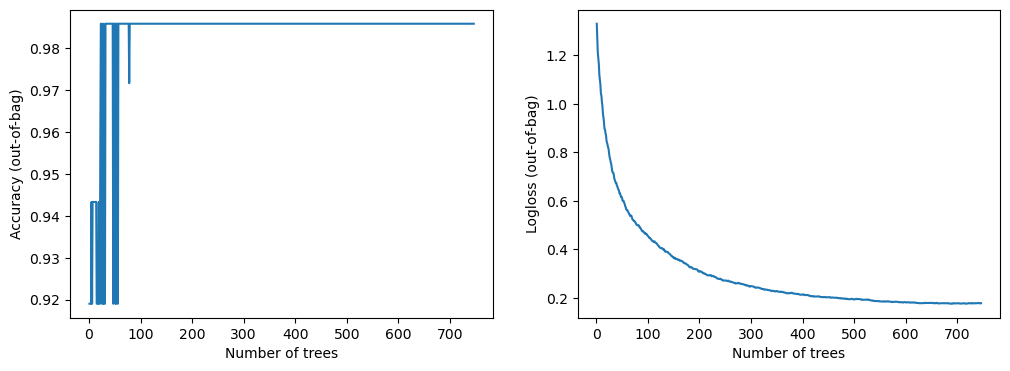


Train: 0.1059 Validation: 0.2613
##### Fold 6
Use /tmp/tmpqilfwzeg as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:00:42.9256 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:42.9256 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:42.9256 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.247611. Found 555 examples.
Training model...
Model trained in 0:00:01.253476
Compiling model...


[INFO 23-07-20 19:00:45.4255 UTC kernel.cc:1242] Loading model from path /tmp/tmpqilfwzeg/model/ with prefix dcf3cda9bda64d51
[INFO 23-07-20 19:00:45.4375 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 19:00:45.4376 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 276ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9355 - balanced_logloss_tf: 0.2744


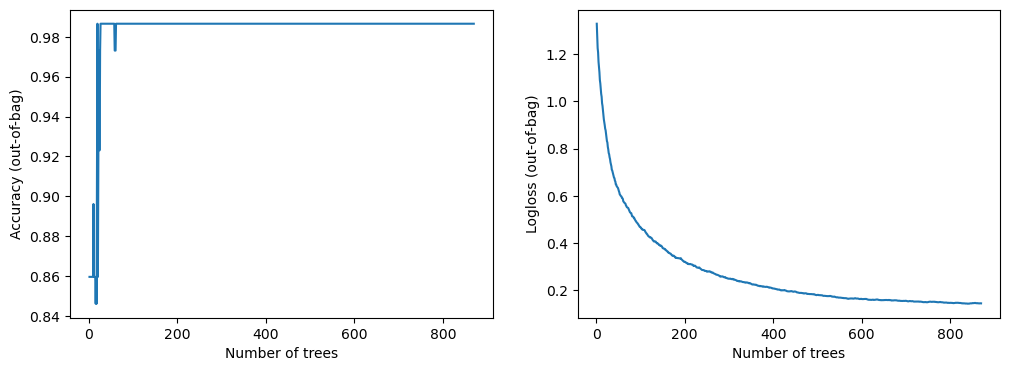


Train: 0.0958 Validation: 0.2744
##### Fold 7
Use /tmp/tmpjjnntktl as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:00:49.3548 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:49.3549 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:49.3549 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.230219. Found 555 examples.
Training model...
Model trained in 0:00:00.580953
Compiling model...


[INFO 23-07-20 19:00:51.1721 UTC kernel.cc:1242] Loading model from path /tmp/tmpjjnntktl/model/ with prefix 3603f9e31feb4c27
[INFO 23-07-20 19:00:51.1774 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 279ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9032 - balanced_logloss_tf: 0.2420


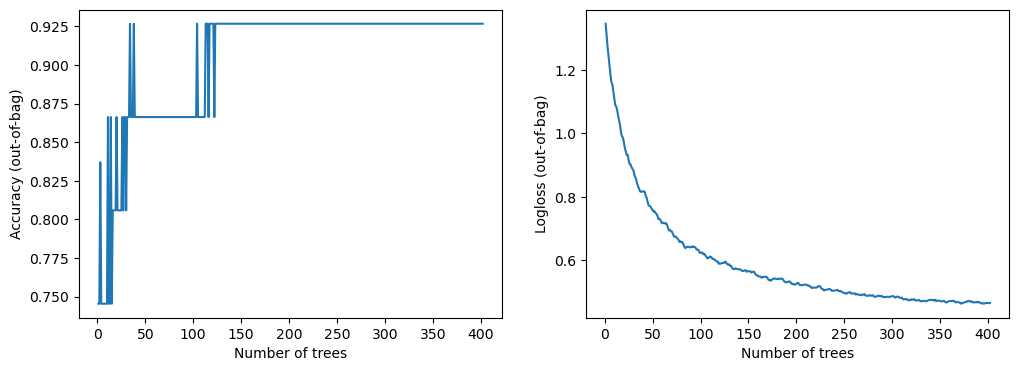


Train: 0.1518 Validation: 0.2420
##### Fold 8
Use /tmp/tmpsmr_8q6n as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:00:55.4453 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:55.4454 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:00:55.4454 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.286597. Found 556 examples.
Training model...
Model trained in 0:00:00.541559
Compiling model...


[INFO 23-07-20 19:00:57.2771 UTC kernel.cc:1242] Loading model from path /tmp/tmpsmr_8q6n/model/ with prefix 678094df481246be
[INFO 23-07-20 19:00:57.2827 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-07-20 19:00:57.2828 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 282ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9180 - balanced_logloss_tf: 0.2632


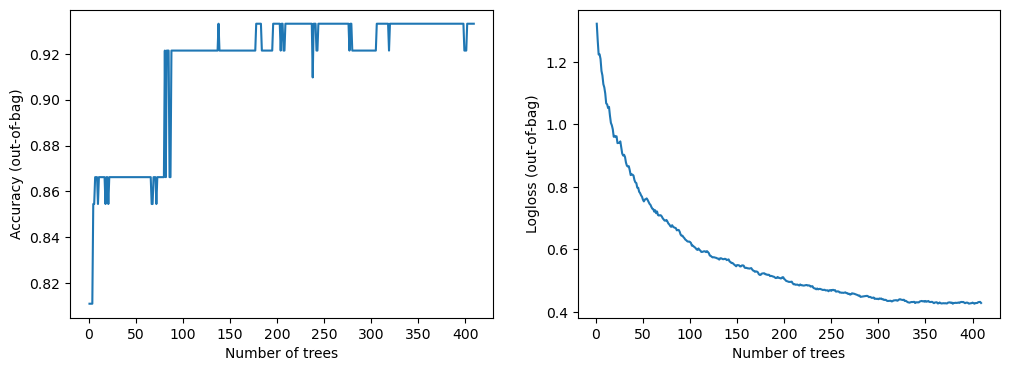


Train: 0.1428 Validation: 0.2632
##### Fold 9
Use /tmp/tmpi4jjstol as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:01:00.3228 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:01:00.3228 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:01:00.3229 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.283416. Found 556 examples.
Training model...
Model trained in 0:00:00.725565
Compiling model...


[INFO 23-07-20 19:01:02.3330 UTC kernel.cc:1242] Loading model from path /tmp/tmpi4jjstol/model/ with prefix c541a87cee564b58
[INFO 23-07-20 19:01:02.3405 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 278ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8852 - balanced_logloss_tf: 0.3122


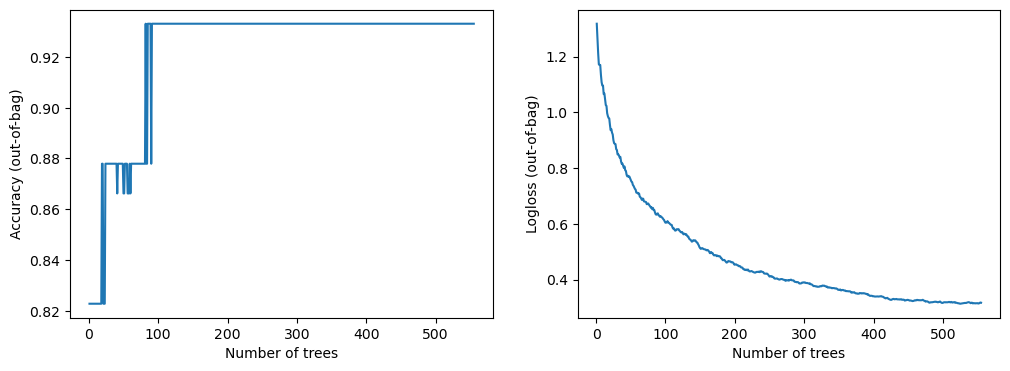


Train: 0.1171 Validation: 0.3122
##### Fold 10
Use /tmp/tmpns1g1eme as temporary training directory
Reading training dataset...


[WARNING 23-07-20 19:01:05.2121 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:01:05.2121 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-07-20 19:01:05.2121 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.302669. Found 556 examples.
Training model...
Model trained in 0:00:00.596567
Compiling model...


[INFO 23-07-20 19:01:07.1146 UTC kernel.cc:1242] Loading model from path /tmp/tmpns1g1eme/model/ with prefix afa2359d2f88474e
[INFO 23-07-20 19:01:07.1207 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 273ms/step - loss: 0.0000e+00 - binary_accuracy: 0.9672 - balanced_logloss_tf: 0.1399


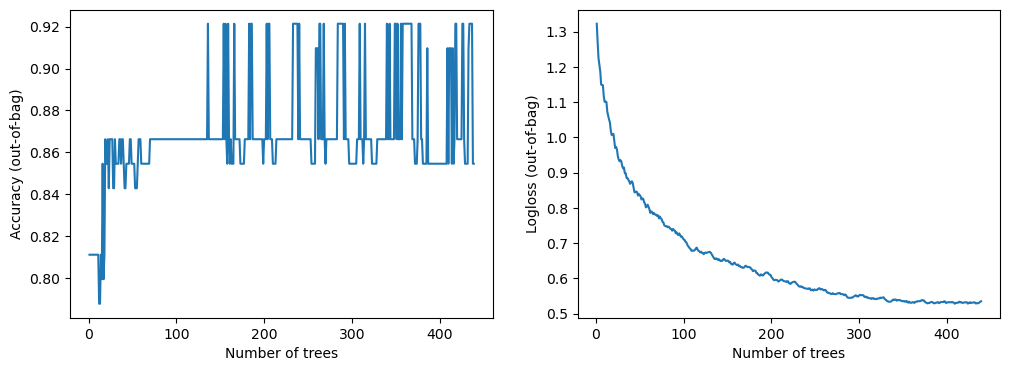


Train: 0.1509 Validation: 0.1399

Train mean: 0.1271 std: 0.0197

Validation mean: 0.2420 std: 0.0670


In [14]:
# GradientBoostedTreesModel

features_slice = [i for i in features if len(i) > 2]

submition_gbt_2, model_gbt_2,metrics_gbt_2 = train_model(
    train=train_out,test=test_out, features=features_slice,                                             
    n_splits=10,                    
    model_obj=tfdf.keras.GradientBoostedTreesModel,            
    model_kwargs=dict(max_depth=2, num_trees=1000),                                                  
    model_compile_kwargs=dict(metrics=[metrics.binary_accuracy, balanced_logloss_tf]))

# TabPFN

In [15]:
def balanced_logloss_np(y_true: np.array, y_pred: np.array) -> float:
    # y_true is prob that y is equals to 1, we assume that final probs would be P(class_1) = 1 - P(class_0)
    y_pred_1 = y_pred
    y_pred_0 = 1-y_pred

    log_y_pred_1 = np.reshape(np.log(y_pred_1),[-1,1])
    log_y_pred_0 = np.reshape(np.log(y_pred_0),[-1,1])

    y_1 = np.reshape(y_true,[1,-1])
    y_0 = (y_1-1)*(-1)

    logloss_1 = -np.dot(y_1,log_y_pred_1)[0][0]/np.sum(y_1)
    logloss_0 = -np.dot(y_0,log_y_pred_0)[0][0]/np.sum(y_0)

    av_logloss = (logloss_1+logloss_0)/2
    
    return av_logloss

In [16]:
def train_model_tabpfn_one(train: pd.DataFrame, submition: pd.DataFrame, features: list, label = "Class") -> (pd.DataFrame, dict, dict):

    # Create a dataframe of required size with zero values.
    submition_df = pd.DataFrame(data=np.zeros((len(submition.index),1)),index=submition.index)
    train_df_out = pd.DataFrame(data=np.zeros((len(train.index),1)),index=train.index)
    # Create an empty dictionary to store the models trained for each fold.
    metrics = {}

    # Select only feature columns for training.
    train_df = train[features+[label]]

    # Define & Train the model and metrics
    model = TabPFNClassifier(N_ensemble_configurations=64)
    model.fit(train_df[features],train_df[label])

    # Make predictions
    p_train = model.predict_proba(train_df[features])[:,1]
    p_sub = model.predict_proba(submition[features])[:,1]

    # Predict value for validation/Submition data
    submition_df[0] = p_sub.flatten() 
    train_df_out[0] = p_train.flatten() 
    
    # Evaluate and store the metrics in respective dicts
            
    # metrics['accuracy'] = accuracy_score(train_df[label].values, p_train)
    train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
    metrics['balanced_logloss'] = train_metric
    print(f"\nTrain: {train_metric:.4f}")
    
            
    return train_df_out,submition_df,model,metrics

In [17]:

def train_model_tabpfn_cv(train: pd.DataFrame, submition: pd.DataFrame, features: list, label = "Class",
                n_splits: int = 6) -> (pd.DataFrame, dict,  dict):

    # Create a dataframe of required size with zero values.
    # out_of_fold = pd.DataFrame(data=np.zeros((len(train.index),1)), index=train.index)
    submition_out = pd.DataFrame(data=np.zeros((len(submition.index),n_splits)),index=submition.index)

    # Create an empty dictionary to store the models trained for each fold.
    models = {}
    metrics = {}
    balanced_logloss_train = {}
    balanced_logloss_val = {}
    
    # Loop through each fold
    skf = StratifiedKFold(n_splits=n_splits)
    
    for i, (train_index, valid_index) in enumerate(skf.split(X=train,y=train['Class'])):
            print('##### Fold',i+1)

            # Fetch values corresponding to the index 
            train_df = train.iloc[train_index]
            valid_df = train.iloc[valid_index]
            valid_ids = valid_df.index.values

            # Select only feature columns for training.
            train_df = train_df[features+[label]]
            valid_df = valid_df[features+[label]]

            # Define & Train the model
            model = TabPFNClassifier(N_ensemble_configurations=64)
            model.fit(train_df[features],train_df[label])

            # Store the model
            models[f"fold_{i+1}"] = model

            # Predict value for validation/Submition data
            # Store the predictions in out_of_fold dataframe
            p_train = model.predict_proba(train_df[features])[:,1]
            p_val = model.predict_proba(valid_df[features])[:,1]
            p_sub = model.predict_proba(submition[features])[:,1]
            
            # out_of_fold.loc[valid_ids, 0] = p_val
            submition_out[i] = p_sub

            # Evaluate and store the metrics in respective dicts
            train_metric = balanced_logloss_np(y_true=train_df[label].values,y_pred=p_train)
            val_metric = balanced_logloss_np(y_true=valid_df[label].values,y_pred=p_val)
            
            balanced_logloss_train[f"fold_{i+1}"] = train_metric
            balanced_logloss_val[f"fold_{i+1}"] = val_metric
            
            print(f"\nTrain: {train_metric:.4f} Validation: {val_metric:.4f}")
    
    metrics['train'] = balanced_logloss_train
    metrics['val'] = balanced_logloss_val

    print(f"\nTrain mean: {pd.Series(balanced_logloss_train).mean():.4f} std: {pd.Series(balanced_logloss_train).std():.4f}")
    print(f"\nValidation mean: {pd.Series(balanced_logloss_val).mean():.4f} std: {pd.Series(balanced_logloss_val).std():.4f}")
            
    return submition,models,metrics

In [18]:
# TabPFN tabpfn_

if not SUBMITION:
    features_slice = [i for i in features if len(i) > 2]
    train_tabpfn_1, submition_tabpfn_1, model_tabpfn_1, metrics_tabpfn_1 = train_model_tabpfn_one(
        train=train_out,submition=test_out, features=features_slice)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0515


In [19]:
# TabPFN tabpfn_
features_slice = [i for i in features if len(i) > 2]
submition_tabpfn_2, model_tabpfn_2, metrics_tabpfn_2 = train_model_tabpfn_cv(
    train=train_out,submition=test_out, features=features_slice, n_splits=6)

##### Fold 1
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0559 Validation: 0.1706
##### Fold 2
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0553 Validation: 0.2929
##### Fold 3
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0538 Validation: 0.2968
##### Fold 4
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0448 Validation: 0.1985
##### Fold 5
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0518 Validation: 0.4682
##### Fold 6
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters

Train: 0.0511 Validation: 0.1178

Train mean: 0.0521 std: 0.0040

Validation mean: 0.2575 std: 0.1247


# Submission

In [20]:
# Aggragate Subs

RF_m = pd.Series(metrics_rf_3['val']).mean()
GBT_m = pd.Series(metrics_gbt_2['val']).mean()
TabPFN_m = pd.Series(metrics_tabpfn_2['val']).mean()

print('RF: metric ', RF_m)
print('GBT: metric ', GBT_m)
print('TabPFN: metric ', TabPFN_m)

Total_m = GBT_m + RF_m + TabPFN_m

RF_w = 2/10
GBT_w = 4.5/10
TabPFN_w = 3.5/10

print('RF weight: ', RF_w)
print('GBT weight: ', GBT_w)
print('TabPFN weight: ', TabPFN_w)

RF: metric  0.2840496152639389
GBT: metric  0.24200911670923234
TabPFN: metric  0.2574768213256095
RF weight:  0.2
GBT weight:  0.45
TabPFN weight:  0.35


In [21]:
submition_total = pd.concat([submition_rf_3.mean(axis=1).to_frame(),
                             submition_gbt_2.mean(axis=1).to_frame(),
                             submition_tabpfn_2.mean(axis=1).to_frame()]
                            ,axis=1)
submition_total.columns = ['RF','GBT','TabPFN']

submition_total['Ensemble'] = RF_w*submition_total['RF'] + GBT_w*submition_total['GBT'] + TabPFN_w*submition_total['TabPFN']

# submition_total
submition_total = submition_total[['Ensemble']].copy()
submition_total.columns = ['class_1']
submition_total['class_0'] = 1 - submition_total['class_1']
submition_total = submition_total[['class_0','class_1']]

/tmp/ipykernel_20/2775741711.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  submition_tabpfn_2.mean(axis=1).to_frame()]


In [22]:
submition_total.to_csv('/kaggle/working/submission.csv', index=True)

In [23]:
submition_total

,class_0,class_1
Id,,
00eed32682bb,0.811332,0.188668
010ebe33f668,0.811332,0.188668
02fa521e1838,0.811332,0.188668
040e15f562a2,0.811332,0.188668
046e85c7cc7f,0.811332,0.188668


In [24]:
submition_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 00eed32682bb to 046e85c7cc7f
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   class_0  5 non-null      float64
 1   class_1  5 non-null      float64
dtypes: float64(2)
memory usage: 120.0+ bytes
